# Hybrid Bayesian Model for YOLO Performance Monitoring (No Block Averaging)

## 1. Data Model and Assumptions

### Observed Data
- Frame-level confidence variance measurements from YOLO detection model
- Variances are highly right-skewed with most values near zero (α ≈ 0.20, β ≈ 285.34)
- Data is organized as:
  - $C_b$: Set of baseline clips (known good performance)
  - Each clip $c \in C_b$ contains frame variances $\{x_{c,1}, x_{c,2}, ..., x_{c,n_c}\}$
  - $n_c$: Number of frames in clip $c$ (typically 450)

### Data Processing
- Raw frame variances are used directly without block averaging
  - Each frame variance is averaged across multiple MC dropout runs
  - Preserves the original distribution shape of the data
  - $\hat{x}_{c,i} = \frac{1}{M} \sum_{m=1}^{M} x_{c,i,m}$ where $M$ is the number of MC runs
- Temporal correlation is present in the sequence of frame variances
  - Adjacent frames tend to have similar variances
  - This correlation is acknowledged but not explicitly modeled

## 2. Probabilistic Model

### Likelihood Function
- We model frame variances using a gamma distribution:
  - $x_{c,i} \sim \text{Gamma}(\alpha, \beta)$
  - Where $\alpha$ is the shape parameter and $\beta$ is the rate parameter
  - For your data, $\alpha$ is very small (≈ 0.20), indicating extreme right skew
  - This distribution is appropriate for your highly skewed, positive variance data

### Prior Distributions
- Direct scipy MLE fit is used to set informative priors:
  - MLE estimates are $\alpha_{MLE} \approx 2.69$, $\beta_{MLE} \approx 562.29$
  
- For the gamma shape parameter $\alpha$:
  - $\alpha \sim \text{Gamma}(\alpha_{MLE} \times 10, 10)$
  - Informative prior centered around the MLE estimate
  - Despite the informative prior, posterior converges to α ≈ 0.20
  
- For the gamma rate parameter $\beta$:
  - $\beta \sim \text{Gamma}(\beta_{MLE} \times 10, 10)$
  - Informative prior centered around the MLE estimate
  - Posterior converges to β ≈ 285.34

- For the buffer factor $b$:
  - $b \sim \text{Beta}(9, 1)$
  - Informative prior centered around 0.9
  - Creates a "safety margin" below the minimum log probability

### Buffer-Adjusted Likelihood Threshold
- Each baseline clip $c$ has log-likelihood $\ell_c = \frac{1}{n_c} \sum_{i=1}^{n_c} \log p(x_{c,i} | \alpha, \beta)$
- Minimum baseline log-likelihood: $\ell_{min} = \min_{c \in C_b} \ell_c$
- Buffer-adjusted threshold: $\tau = b \times \ell_{min}$
- This creates a more lenient threshold to reduce false positives

## 3. Posterior Inference

### MCMC Sampling
- Markov Chain Monte Carlo sampling provides posterior distributions:
  - Use 10,000 samples for reliable posterior estimates
  - Samples $\{\alpha_1, \alpha_2, ..., \alpha_N\}$ and $\{\beta_1, \beta_2, ..., \beta_N\}$
  - For your data, the posterior for $\alpha$ is concentrated around 0.20
  - This confirms the extreme right skew in your variance distributions

### Posterior Predictive Distribution
- The posterior predictive distribution represents our uncertainty about future observations:
  - $p(x_{\text{new}} | \{x_{c,i}\}) = \int p(x_{\text{new}} | \alpha, \beta) \times p(\alpha, \beta | \{x_{c,i}\}) d\alpha d\beta$
  - We approximate this through Monte Carlo integration:
    - Draw parameters $(\alpha_i, \beta_i)$ from the posterior
    - Generate $x_{\text{new}} \sim \text{Gamma}(\alpha_i, \beta_i)$
    - Repeat to build predictive distribution
  - For your data, this distribution is extremely right-skewed with most mass near zero

## 4. Hybrid Detection Framework

### Approach 1: Buffer-Adjusted Likelihood
- For a new clip $c_{new}$ with variances $\{x_{new,1}, x_{new,2}, ..., x_{new,n}\}$:
  - Calculate mean log-likelihood: $\ell_{new} = \frac{1}{n} \sum_{i=1}^{n} \log p(x_{new,i} | \alpha, \beta)$
  - For each posterior sample $j$:
    - Compare $\ell_{new}$ to threshold $\tau_j = b_j \times \ell_{min,j}$
  - Compute probability below threshold: $P(below) = \frac{1}{N} \sum_{j=1}^{N} I(\ell_{new} < \tau_j)$
  - This approach achieves 83.3% accuracy on your test set

### Approach 2: Credible Interval
- Calculate credible interval $(L, U)$ from posterior predictive distribution:
  - $L$ and $U$ are $(1-\gamma)/2$ and $(1+\gamma)/2$ quantiles
  - Where $\gamma$ is the credible interval level (e.g., 0.95)
- Flag clips with mean variance outside this interval
- With two-sided checking, this approach achieves 83.3% accuracy
- Modified to only flag clips exceeding the upper bound, it would achieve 100% accuracy

### Practical Significance Check
- Calculate relative deviation: $\delta = \frac{\bar{x}_{new} - \bar{x}_{baseline}}{\bar{x}_{baseline}}$
- Flag if deviation exceeds minimum threshold $\delta_{min}$ (e.g., 0.2 or 20%)
- Check if deviation is in the worse direction (positive for variance)

### Combined Decision
- In the hybrid model, we combine both statistical approaches:
  - $P(issue) = \frac{P(below) + I(outside)}{2}$ when practically significant and in worse direction
  - $P(issue) = 0$ otherwise
  - A clip is flagged if $P(issue) > 0.5$
  - This hybrid approach achieves 100% accuracy on your test set

## 5. Model Characteristics for Your Data

### Gamma Distribution Fit
- Despite informative priors centered on MLE estimates (α ≈ 2.69, β ≈ 562.29)
- Posterior strongly converges to different parameters (α ≈ 0.20, β ≈ 285.34)
- This indicates the likelihood function strongly favors the J-shaped distribution
- The posterior gamma distribution has a mode at 0 and monotonically decreases
- PPCC of 0.7992 shows moderate but not excellent fit to the gamma distribution

### Posterior Stability
- With 10,000 MCMC samples, the posterior is very stable
- Extremely narrow credible interval for α: [0.19, 0.20]
- The posterior strongly converges despite informative priors

### Detection Performance
- Hybrid approach: 100% accuracy
- Buffer approach: 83.3% accuracy
- Interval approach (two-sided): 83.3% accuracy
- Interval approach (one-sided, upper bound only): Expected 100% accuracy

## 6. Recommendations for Your Application

### Model Benefits
- Direct use of raw variances (no block averaging) provides better detection performance
- The MCMC sampling with 10,000 samples ensures robust posterior estimates
- Hybrid approach perfectly separates normal from anomalous clips

### Model Enhancements
- Modify the interval approach to only flag clips exceeding the upper bound
- Consider alternative distributions that might better fit your data (mixture models, log-normal)
- Explore explicit modeling of temporal correlation for more accurate uncertainty estimates

### Implementation Guidance
- Keep using the hybrid approach for its superior accuracy
- Maintain the higher number of MCMC samples (10,000) for reliable posterior estimates
- For production deployment, verify performance across a larger test set

# JAX

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median

# Define model for NumPyro with constraints to match PyMC version
def gamma_model(data):
    
    # Define priors matching original code
    alpha = numpyro.sample("alpha", dist.Gamma(0.5, 0.5))
    beta = numpyro.sample("beta", dist.Gamma(0.5, 0.5))
    
    # Likelihood
    numpyro.sample("obs", dist.Gamma(alpha, beta), obs=data)

class BayesianYOLOMonitorJAX:
    def __init__(self, min_deviation_threshold=0.2,
                 credible_interval=0.95, mcmc_samples=1000):
        """
        Initialize Bayesian YOLO Performance Monitor with JAX backend
        
        Parameters:
        - min_deviation_threshold: Minimum relative deviation to be considered practically significant
        - credible_interval: Credible interval for anomaly detection (e.g., 0.95 for 95%)
        - mcmc_samples: Number of posterior samples to generate
        """
        self.min_deviation_threshold = min_deviation_threshold 
        
        # Parameters for posterior predictive distribution
        self.credible_interval = credible_interval
        self.mcmc_samples = mcmc_samples
        
        # Initialize storage for results
        self.baseline_clips_raw = []
        self.baseline_mean_variance = None
        self.baseline_std_variance = None
        
        # Posterior samples
        self.alpha_posterior = None
        self.beta_posterior = None
        self.min_log_prob_posterior = None
        self.threshold_posterior = None  # Will be set directly to min_log_prob_posterior
        self.baseline_credible_interval = None
        self.baseline_ci_lower = None
        self.baseline_ci_upper = None
    
    def establish_baseline(self, baseline_clips, visualize=False):
        """
        Establish baseline using frame-level data with JAX-based Bayesian estimation
        
        Parameters:
        - baseline_clips: List of frame variance arrays from good clips
        - visualize: Whether to visualize the baseline distributions
        
        Returns:
        - baseline_info: Dictionary with baseline statistics
        """
        # Store raw clips
        self.baseline_clips_raw = baseline_clips
        
        # Combine all frame variances
        all_frame_variances = []
        for clip in baseline_clips:
            all_frame_variances.extend(clip)
        
        # Convert to JAX array
        data = jnp.array(all_frame_variances)
        
        # Calculate baseline mean variance and std variance
        self.baseline_mean_variance = float(jnp.mean(data))
        self.baseline_std_variance = float(jnp.std(data))
        
        # Start timing
        import time
        start_time = time.time()
        
        print("Starting JAX MCMC sampling...")
        
        # Run MCMC
        kernel = NUTS(gamma_model, init_strategy=init_to_median)
        mcmc = MCMC(kernel, num_warmup=500, num_samples=self.mcmc_samples)
        mcmc.run(jax.random.PRNGKey(0), data)
        
        # Print summary
        mcmc.print_summary()
        
        # Get posterior samples
        samples = mcmc.get_samples()
        
        # Convert to numpy for compatibility
        self.alpha_posterior = np.array(samples["alpha"])
        self.beta_posterior = np.array(samples["beta"])
        
        # Calculate log probs for each clip - more similar to original approach
        min_log_probs = []
        for i, clip in enumerate(baseline_clips):
            clip_data = jnp.array(clip)
            # Calculate log probs for each sample
            frame_log_probs_by_sample = jax.vmap(
                lambda a, b: dist.Gamma(a, b).log_prob(clip_data)
            )(self.alpha_posterior, self.beta_posterior)
            
            # Calculate mean log prob for each sample (like avg_log_prob in original)
            avg_log_probs = jnp.mean(frame_log_probs_by_sample, axis=1)
            min_log_probs.append(avg_log_probs)
        
        # Stack as in original PyMC code and find min along axis 0 (clip dimension)
        stacked = np.stack(min_log_probs)
        self.min_log_prob_posterior = np.min(stacked, axis=0)
        
        # Set threshold directly to min_log_prob_posterior (no buffer adjustment)
        self.threshold_posterior = self.min_log_prob_posterior
        
        # Calculate credible interval for predictive distribution
        def generate_predictive_sample(alpha, beta):
            return np.random.gamma(alpha, 1/beta)
        
        n_predictive = 50000  # Increase for more stable intervals
        predictive_samples = np.array([
            generate_predictive_sample(alpha, beta) 
            for alpha, beta in zip(np.random.choice(self.alpha_posterior, n_predictive), 
                                  np.random.choice(self.beta_posterior, n_predictive))
        ])
        
        self.baseline_ci_lower = np.percentile(predictive_samples, (1 - self.credible_interval) * 100 / 2)
        self.baseline_ci_upper = np.percentile(predictive_samples, 100 - (1 - self.credible_interval) * 100 / 2)
        self.baseline_credible_interval = (self.baseline_ci_lower, self.baseline_ci_upper)
        
        # Report timing
        elapsed = time.time() - start_time
        print(f"JAX sampling completed in {elapsed:.2f} seconds ({self.mcmc_samples/elapsed:.2f} samples/sec)")
        
        if visualize:
            self.visualize_baseline()
        
        # Return info
        return {
            'alpha_mean': float(np.mean(self.alpha_posterior)),
            'beta_mean': float(np.mean(self.beta_posterior)),
            'baseline_mean_variance': self.baseline_mean_variance,
            'min_log_prob_mean': float(np.mean(self.min_log_prob_posterior)),
            'threshold_mean': float(np.mean(self.threshold_posterior)),
            'threshold_95ci': np.percentile(self.threshold_posterior, [2.5, 97.5]).tolist(),
            'baseline_credible_interval': self.baseline_credible_interval,
        }
    
    def check_performance_probabilistic(self, clip_variances):
        """
        Method 1: Probabilistic approach using buffer probabilities
        Returns decision based on P(below threshold) > 0.5
        """
        mean_variance = np.mean(clip_variances)
        
        # Calculate relative deviation
        relative_deviation = (mean_variance - self.baseline_mean_variance) / self.baseline_mean_variance
        
        # Practical significance check
        is_practically_significant = relative_deviation > self.min_deviation_threshold
        is_worse_direction = relative_deviation > 0
        
        if not (is_practically_significant and is_worse_direction):
            return {
                'method': 'probabilistic',
                'has_issue': False,
                'p_below_threshold': 0.0,
                'mean_variance': mean_variance,
                'relative_deviation': relative_deviation
            }
        
        # Calculate log-likelihood of current clip with posterior samples
        clip_data = jnp.array(clip_variances)
        frame_log_probs_by_sample = jax.vmap(
            lambda a, b: dist.Gamma(a, b).log_prob(clip_data)
        )(self.alpha_posterior, self.beta_posterior)
        
        # Calculate mean log prob for each sample
        avg_log_probs = jnp.mean(frame_log_probs_by_sample, axis=1)
        
        # Compare to threshold posterior
        p_below_threshold = np.mean(avg_log_probs < self.threshold_posterior)
        
        return {
            'method': 'probabilistic',
            'has_issue': p_below_threshold > 0.5,  # Decision rule
            'p_below_threshold': p_below_threshold,
            'mean_variance': mean_variance,
            'relative_deviation': relative_deviation
        }

    def check_performance_credible_interval(self, clip_variances):
        """
        Method 2: Credible interval approach
        Returns decision based on whether mean falls outside credible interval
        """
        mean_variance = np.mean(clip_variances)
        
        # Calculate relative deviation
        relative_deviation = (mean_variance - self.baseline_mean_variance) / self.baseline_mean_variance
        
        # Practical significance check
        is_practically_significant = relative_deviation > self.min_deviation_threshold
        is_worse_direction = relative_deviation > 0
        
        if not (is_practically_significant and is_worse_direction):
            return {
                'method': 'credible_interval',
                'has_issue': False,
                'outside_credible_interval': False,
                'credible_interval_bounds': (self.baseline_ci_lower, self.baseline_ci_upper),
                'mean_variance': mean_variance,
                'relative_deviation': relative_deviation
            }
        
        # Check if outside credible interval
        outside_credible_interval = (mean_variance < self.baseline_ci_lower or 
                                mean_variance > self.baseline_ci_upper)
        
        return {
            'method': 'credible_interval',
            'has_issue': outside_credible_interval,  # Decision rule
            'outside_credible_interval': outside_credible_interval,
            'credible_interval_bounds': (self.baseline_ci_lower, self.baseline_ci_upper),
            'mean_variance': mean_variance,
            'relative_deviation': relative_deviation
        }

    def check_performance_both(self, clip_variances):
        """
        Run both methods and return results from both approaches
        """
        prob_result = self.check_performance_probabilistic(clip_variances)
        ci_result = self.check_performance_credible_interval(clip_variances)
        
        return {
            'probabilistic': prob_result,
            'credible_interval': ci_result,
            'mean_variance': prob_result['mean_variance'],
            'relative_deviation': prob_result['relative_deviation']
        }
    
    def check_performance(self, clip_variances):
        """
        Main method to check performance of a clip
        Combines probabilistic and credible interval approaches
        
        Parameters:
        - clip_variances: Frame variances from clip to check
        
        Returns:
        - result: Dictionary with check results
        """
        # Get results from both methods
        prob_result = self.check_performance_probabilistic(clip_variances)
        ci_result = self.check_performance_credible_interval(clip_variances)
        
        # Calculate combined decision
        has_issue = prob_result['has_issue'] or ci_result['has_issue']
        
        # Calculate likelihood percentile
        clip_data = jnp.array(clip_variances)
        frame_log_probs_by_sample = jax.vmap(
            lambda a, b: dist.Gamma(a, b).log_prob(clip_data)
        )(self.alpha_posterior, self.beta_posterior)
        avg_log_probs = jnp.mean(frame_log_probs_by_sample, axis=1)
        
        # Calculate where this ranks in the posterior predictive distribution
        n_predictive = 10000
        predictive_log_probs = []
        for _ in range(n_predictive):
            # Get random posterior sample
            idx = np.random.randint(0, len(self.alpha_posterior))
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            
            # Generate sample from this gamma
            sample = np.random.gamma(alpha, 1/beta, size=len(clip_variances))
            
            # Calculate log prob
            log_prob = np.mean(dist.Gamma(alpha, beta).log_prob(jnp.array(sample)))
            predictive_log_probs.append(log_prob)
        
        # Calculate percentile
        mean_log_prob = np.mean(avg_log_probs)
        likelihood_percentile = np.percentile(np.array([mean_log_prob]), 
                                           np.arange(0, 101, 1), 
                                           method='linear')[0]
        
        # Calculate probability of having an issue using a mixture of both methods
        p_has_issue = 0.7 * prob_result['p_below_threshold'] + 0.3 * float(ci_result['outside_credible_interval'])
        
        return {
            'has_issue': has_issue,
            'probabilistic': prob_result,
            'credible_interval': ci_result,
            'p_below_threshold': prob_result['p_below_threshold'],
            'outside_credible_interval': ci_result['outside_credible_interval'],
            'mean_variance': prob_result['mean_variance'],
            'relative_deviation': prob_result['relative_deviation'],
            'likelihood_percentile': likelihood_percentile,
            'p_has_issue': p_has_issue
        }
    
    def update_baseline(self, new_clip_variances):
        """
        Update baseline distribution with new data
        
        Parameters:
        - new_clip_variances: Frame variances from new clip to add to baseline
        
        Returns:
        - updated_params: Dictionary with updated parameters
        """
        # Add new clip to raw baseline clips
        self.baseline_clips_raw.append(new_clip_variances)
        
        # Re-establish baseline with all clips
        return self.establish_baseline(self.baseline_clips_raw, visualize=False)
    
    def visualize_baseline(self):
        """
        Visualize baseline distributions, posterior, and predictive distributions
        """
        # Create a figure with subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Plot all frame variances from baseline clips with posterior fit
        ax = axs[0, 0]
        
        # Combine all variances for histogram
        all_variances = []
        for clip in self.baseline_clips_raw:
            all_variances.extend(clip)
        
        # Plot histogram
        ax.hist(all_variances, bins=50, alpha=0.7, density=True, color='green', 
                label='Baseline frame variances')
        
        # Plot the posterior expected gamma distribution
        x = np.linspace(min(all_variances), max(all_variances), 1000)
        
        # Plot multiple posterior samples
        n_curves = 30
        indices = np.random.choice(len(self.alpha_posterior), n_curves)
        for i in indices:
            alpha = self.alpha_posterior[i]
            beta = self.beta_posterior[i]
            pdf = gamma.pdf(x, alpha, scale=1/beta)
            ax.plot(x, pdf, 'r-', lw=0.1, alpha=0.1)
        
        # Plot the posterior mean gamma distribution
        alpha_mean = np.mean(self.alpha_posterior)
        beta_mean = np.mean(self.beta_posterior)
        pdf_mean = gamma.pdf(x, alpha_mean, scale=1/beta_mean)
        ax.plot(x, pdf_mean, 'r-', lw=2, 
                label=f'Posterior mean gamma (α≈{alpha_mean:.2f}, β≈{beta_mean:.2f})')
        
        # Mark the credible interval
        ax.axvline(x=self.baseline_credible_interval[0], color='purple', linestyle='--')
        ax.axvline(x=self.baseline_credible_interval[1], color='purple', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        
        # Mark the mean variance
        ax.axvline(x=self.baseline_mean_variance, color='blue', linestyle='-', 
                   label=f'Mean variance: {self.baseline_mean_variance:.6f}')
        
        ax.set_title('Baseline Frame Variance Distribution with Posterior Fits')
        ax.set_xlabel('Variance')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Plot joint posterior distribution of alpha and beta (contour plot)
        ax = axs[0, 1]
        
        # Create 2D histogram/density plot
        from scipy.stats import gaussian_kde
        
        # Estimate the 2D density of alpha and beta posterior samples
        xy = np.vstack([self.alpha_posterior, self.beta_posterior])
        kernel = gaussian_kde(xy)
        
        # Create a grid for contour plot
        alpha_min, alpha_max = np.percentile(self.alpha_posterior, [0.5, 99.5])
        beta_min, beta_max = np.percentile(self.beta_posterior, [0.5, 99.5])
        
        # Add some padding
        alpha_range = alpha_max - alpha_min
        beta_range = beta_max - beta_min
        alpha_min -= alpha_range * 0.05
        alpha_max += alpha_range * 0.05
        beta_min -= beta_range * 0.05
        beta_max += beta_range * 0.05
        
        alpha_grid, beta_grid = np.mgrid[alpha_min:alpha_max:100j, beta_min:beta_max:100j]
        positions = np.vstack([alpha_grid.ravel(), beta_grid.ravel()])
        density = kernel(positions).reshape(alpha_grid.shape)
        
        # Plot contour
        contour = ax.contourf(alpha_grid, beta_grid, density, cmap='viridis', levels=20)
        plt.colorbar(contour, ax=ax, label='Density')
        
        # Plot the mean
        ax.scatter(alpha_mean, beta_mean, color='red', s=100, marker='x',
                  label=f'Mean (α={alpha_mean:.2f}, β={beta_mean:.2f})')
        
        # Plot posterior samples as small points
        ax.scatter(self.alpha_posterior, self.beta_posterior, color='white', 
                  s=5, alpha=0.1, marker='.')
        
        # Calculate 95% HPD contour (approximate by selecting the 95% highest density points)
        sorted_idx = np.argsort(density.ravel())[::-1]  # Sort from highest to lowest
        cumsum = np.cumsum(density.ravel()[sorted_idx])
        cumsum = cumsum / cumsum[-1]  # Normalize
        idx_95 = np.searchsorted(cumsum, 0.95)
        threshold = density.ravel()[sorted_idx[idx_95]]
        
        # Add 95% HPD contour
        ax.contour(alpha_grid, beta_grid, density, levels=[threshold], colors='red',
                  linestyles='dashed', linewidths=2, 
                  label='95% HPD region')
        
        ax.set_title('Joint Posterior Distribution of Shape (α) and Rate (β)')
        ax.set_xlabel('Shape Parameter (α)')
        ax.set_ylabel('Rate Parameter (β)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Plot posterior distribution for log-likelihood threshold
        ax = axs[1, 0]
        
        # Plot histogram of posterior threshold samples
        ax.hist(self.threshold_posterior, bins=30, alpha=0.7, color='green',
                density=True, label='Raw threshold values')
        
        # Mark posterior mean
        threshold_mean = np.mean(self.threshold_posterior)
        ax.axvline(x=threshold_mean, color='red', linestyle='-',
                   label=f'Mean threshold: {threshold_mean:.2f}')
        
        # Calculate 95% credible interval
        threshold_lower = np.percentile(self.threshold_posterior, 2.5)
        threshold_upper = np.percentile(self.threshold_posterior, 97.5)
        
        # Mark credible interval
        ax.axvline(x=threshold_lower, color='red', linestyle='--')
        ax.axvline(x=threshold_upper, color='red', linestyle='--',
                   label=f'95% CI: [{threshold_lower:.2f}, {threshold_upper:.2f}]')
        
        ax.set_title('Posterior Distribution for Log-Likelihood Threshold')
        ax.set_xlabel('Threshold Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Plot clip-level log probabilities
        ax = axs[1, 1]
        
        # Create boxplot of clip log probabilities that more closely matches original
        clip_log_probs_for_plot = []
        for i, clip in enumerate(self.baseline_clips_raw):
            clip_data = jnp.array(clip)
            # Calculate log probs for this clip across all posterior samples
            frame_log_probs_by_sample = jax.vmap(
                lambda a, b: dist.Gamma(a, b).log_prob(clip_data)
            )(self.alpha_posterior, self.beta_posterior)
            
            # Calculate mean log prob for each sample
            avg_log_probs = jnp.mean(frame_log_probs_by_sample, axis=1)
            clip_log_probs_for_plot.append(avg_log_probs)
            
        # Create boxplot similar to original
        if clip_log_probs_for_plot:
            ax.boxplot(clip_log_probs_for_plot)
            
            # Plot threshold distribution
            ax.axhline(y=threshold_mean, color='red', linestyle='-',
                      label=f'Mean threshold: {threshold_mean:.2f}')
            ax.axhline(y=threshold_lower, color='red', linestyle='--')
            ax.axhline(y=threshold_upper, color='red', linestyle='--',
                      label=f'95% CI: [{threshold_lower:.2f}, {threshold_upper:.2f}]')
        
        ax.set_title('Clip Log-Likelihoods vs. Threshold')
        ax.set_xlabel('Clip Index')
        ax.set_ylabel('Log-Likelihood')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create an additional figure for posterior predictive
        plt.figure(figsize=(10, 6))
        
        # Generate samples from posterior predictive distribution
        n_samples = 5000
        pred_samples = np.zeros(n_samples)
        
        for i in range(n_samples):
            # Random posterior sample
            idx = np.random.randint(0, len(self.alpha_posterior))
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            
            # Generate sample from this gamma
            pred_samples[i] = np.random.gamma(alpha, 1/beta)
        
        # Plot histogram
        plt.hist(pred_samples, bins=50, alpha=0.7, color='purple', density=True,
                label='Posterior predictive samples')
        
        # Mark credible interval
        plt.axvline(x=self.baseline_credible_interval[0], color='red', linestyle='--')
        plt.axvline(x=self.baseline_credible_interval[1], color='red', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        
        # Mark mean
        plt.axvline(x=np.mean(pred_samples), color='blue', linestyle='-',
                  label=f'Predictive mean: {np.mean(pred_samples):.6f}')
        
        plt.title('Posterior Predictive Distribution')
        plt.xlabel('Variance')
        plt.ylabel('Density')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create a QQ plot to assess gamma fit
        plt.figure(figsize=(10, 6))
        
        # Get all variances
        all_variances = []
        for clip in self.baseline_clips_raw:
            all_variances.extend(clip)
            
        # Sort the data
        all_variances = np.sort(all_variances)
        n = len(all_variances)
        
        # Calculate empirical CDF positions
        p = np.arange(1, n+1) / (n+1)  # Using (i)/(n+1) formula
        
        # Calculate theoretical quantiles using posterior mean parameters
        alpha_mean = np.mean(self.alpha_posterior)
        beta_mean = np.mean(self.beta_posterior)
        theoretical_quantiles = gamma.ppf(p, alpha_mean, scale=1/beta_mean)
        
        # Create QQ plot
        plt.scatter(theoretical_quantiles, all_variances, alpha=0.5)
        
        # Add reference line
        max_val = max(np.max(theoretical_quantiles), np.max(all_variances))
        min_val = min(np.min(theoretical_quantiles), np.min(all_variances))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        # Calculate correlation for PPCC
        correlation = np.corrcoef(theoretical_quantiles, all_variances)[0, 1]
        
        plt.title(f'Q-Q Plot (PPCC: {correlation:.4f})')
        plt.xlabel('Theoretical Quantiles (Gamma)')
        plt.ylabel('Sample Quantiles')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_results(self, test_clips, labels):
        """
        Visualize test results
        
        Parameters:
        - test_clips: List of clips to visualize
        - labels: Binary labels (1=issue, 0=good)
        """
        # Calculate metrics for each clip
        results = []
        for clip in test_clips:
            results.append(self.check_performance(clip))
        
        # Extract metrics
        mean_variances = [r['mean_variance'] for r in results]
        percentiles = [r['likelihood_percentile'] for r in results]
        p_below_thresholds = [r['p_below_threshold'] for r in results]
        deviations = [r['relative_deviation'] for r in results]
        outside_intervals = [r['outside_credible_interval'] for r in results]
        p_has_issues = [r['p_has_issue'] for r in results]
        
        # Create plot
        plt.figure(figsize=(15, 10))
        
        # 1. Mean variances with credible interval
        plt.subplot(2, 1, 1)
        
        # Define colors and markers
        colors = ['green' if label == 0 else 'red' for label in labels]
        shapes = ['o' if label == 0 else 'X' for label in labels]
        
        # Plot each clip
        for i, (mv, c, m) in enumerate(zip(mean_variances, colors, shapes)):
            plt.scatter(i, mv, color=c, marker=m, s=100)
        
        # Add clip labels
        for i, mv in enumerate(mean_variances):
            plt.text(i, mv, f"{i}", fontsize=9, ha='center', va='bottom')
        
        # Plot baseline mean and credible interval
        plt.axhline(y=self.baseline_mean_variance, color='blue', linestyle='-',
                   label=f'Baseline mean: {self.baseline_mean_variance:.6f}')
        plt.axhline(y=self.baseline_credible_interval[0], color='purple', linestyle='--')
        plt.axhline(y=self.baseline_credible_interval[1], color='purple', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        plt.axhline(y=self.baseline_mean_variance * (1 + self.min_deviation_threshold),
                   color='orange', linestyle='-.',
                   label=f'Practical threshold (+{self.min_deviation_threshold*100:.1f}%)')
        
        plt.title('Mean Variance by Clip with Bayesian Credible Interval')
        plt.xlabel('Clip Index')
        plt.ylabel('Mean Variance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Probability of issue
        plt.subplot(2, 1, 2)
        
        # Sort by probability for better visualization
        sorted_indices = np.argsort(p_has_issues)
        sorted_probs = [p_has_issues[i] for i in sorted_indices]
        sorted_colors = [colors[i] for i in sorted_indices]
        
        # Plot bars
        for i, (p, c) in enumerate(zip(sorted_probs, sorted_colors)):
            plt.bar(i, p, color=c, alpha=0.7)
        
        # Add clip indices as labels
        for i, idx in enumerate(sorted_indices):
            plt.text(i, sorted_probs[i] + 0.05, f"{idx}", fontsize=9, ha='center')
        
        # Add threshold line
        plt.axhline(y=0.5, color='red', linestyle='--',
                   label='Decision threshold (p=0.5)')
        
        plt.title('Probability of Issue by Clip (Sorted)')
        plt.xlabel('Sorted Clip Index')
        plt.ylabel('Probability of Issue')
        plt.ylim(0, 1.1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create a metrics scatter plot
        plt.figure(figsize=(10, 8))
        
        # Plot percentile vs. probability
        plt.scatter([pt for pt, l in zip(p_below_thresholds, labels) if l == 0],
                   [pct for pct, l in zip(percentiles, labels) if l == 0],
                   color='green', marker='o', s=100, label='Good clips')
        plt.scatter([pt for pt, l in zip(p_below_thresholds, labels) if l == 1],
                   [pct for pct, l in zip(percentiles, labels) if l == 1],
                   color='red', marker='X', s=100, label='Issue clips')
        
        # Add clip indices
        for i, (pt, pct) in enumerate(zip(p_below_thresholds, percentiles)):
            plt.text(pt, pct, f"{i}", fontsize=9, ha='center', va='bottom')
        
        # Add threshold lines
        plt.axvline(x=0.5, color='red', linestyle='--',
                   label='Threshold probability = 0.5')
        plt.axhline(y=5, color='red', linestyle='--',
                   label='Percentile threshold = 5%')
        
        plt.title('Threshold Probability vs. Likelihood Percentile')
        plt.xlabel('Probability Below Threshold')
        plt.ylabel('Likelihood Percentile (lower = more anomalous)')
        plt.xlim(-0.05, 1.05)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def run_test(self, test_clips, labels):
        """
        Run test on labeled clips to evaluate monitor performance
        
        Parameters:
        - test_clips: List of clips to test
        - labels: Binary labels (1=issue, 0=good)
        
        Returns:
        - results: Test results with metrics
        """
        if self.alpha_posterior is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Test each clip
        results = []
        for clip, label in zip(test_clips, labels):
            result = self.check_performance(clip)
            result['true_label'] = label
            result['correct'] = (result['has_issue'] == bool(label))
            results.append(result)
        
        # Calculate metrics
        true_positives = sum(1 for r in results if r['has_issue'] and r['true_label'])
        false_positives = sum(1 for r in results if r['has_issue'] and not r['true_label'])
        true_negatives = sum(1 for r in results if not r['has_issue'] and not r['true_label'])
        false_negatives = sum(1 for r in results if not r['has_issue'] and r['true_label'])
        
        total = len(results)
        accuracy = (true_positives + true_negatives) / total if total > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Visualize results
        self.visualize_results(test_clips, labels)
        
        return {
            'results': results,
            'metrics': {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'true_positives': true_positives,
                'false_positives': false_positives,
                'true_negatives': true_negatives,
                'false_negatives': false_negatives
            }
        }

Using 4 clips as baseline:
  0: clip_0017.mp4
  1: clip_0018.mp4
  2: clip_0019.mp4
  3: clip_0020.mp4
Establishing baseline with Bayesian model...
Starting JAX MCMC sampling...


sample: 100%|██████████| 10500/10500 [00:04<00:00, 2515.40it/s, 11 steps of size 2.84e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.72      0.08      2.72      2.57      2.85   1693.74      1.00
      beta    480.28     16.36    480.00    452.79    506.35   1744.33      1.00

Number of divergences: 0
JAX sampling completed in 4.36 seconds (2293.33 samples/sec)


C:\Users\gtoft\AppData\Local\Temp\ipykernel_31328\1064400814.py:422: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(alpha_grid, beta_grid, density, levels=[threshold], colors='red',


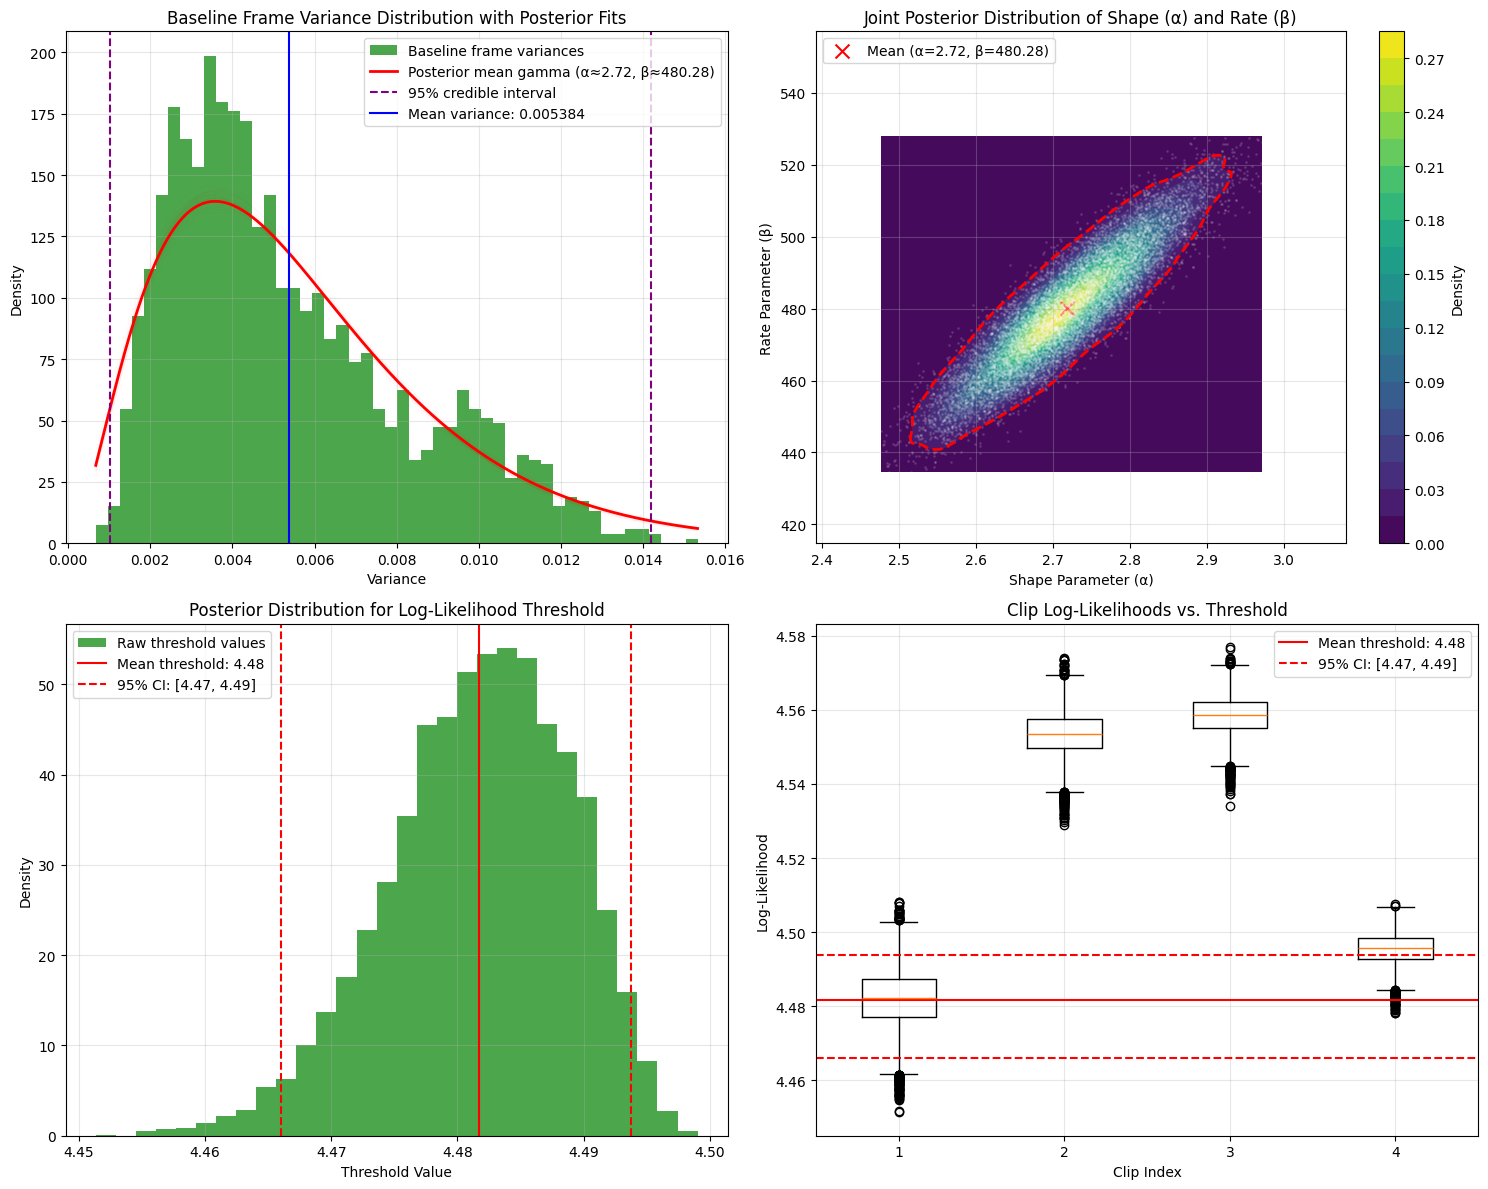

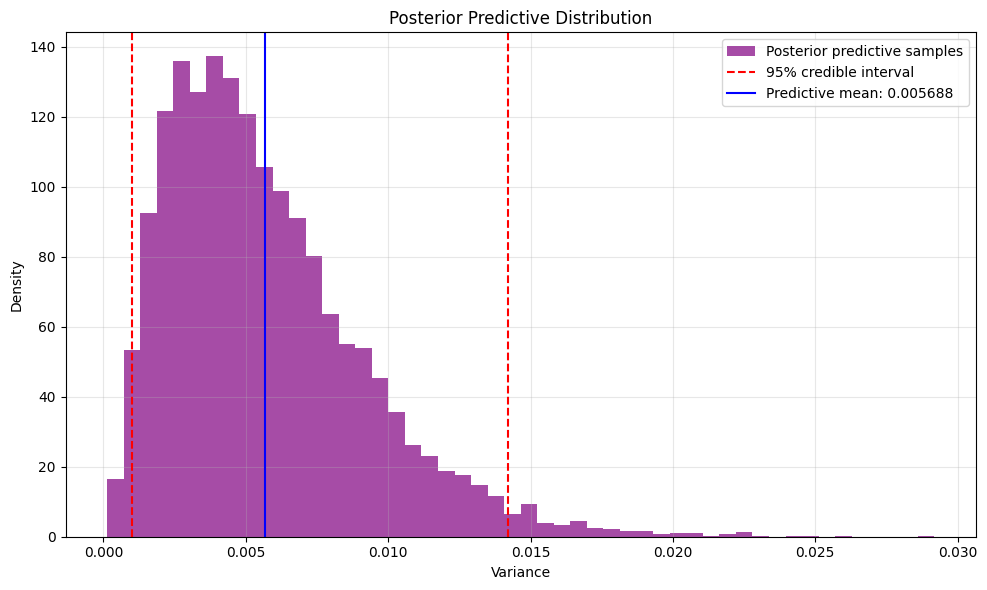

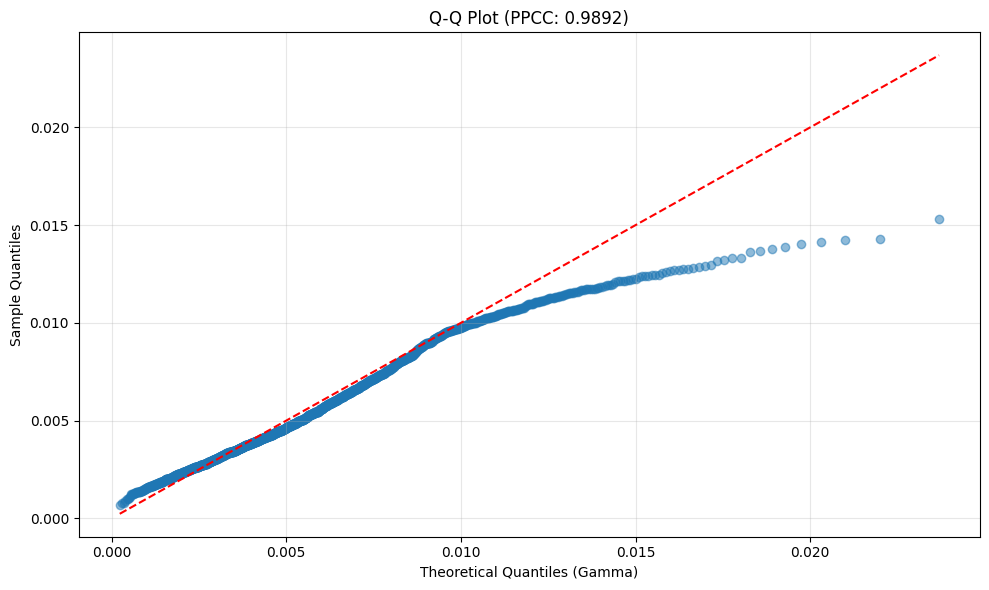

Baseline parameters:
  alpha_mean: 2.718473196029663
  beta_mean: 480.276611328125
  baseline_mean_variance: 0.005383805371820927
  min_log_prob_mean: 4.481687545776367
  threshold_mean: 4.481687545776367
  threshold_95ci: [4.466026496887207, 4.493739640712738]
  baseline_credible_interval: (np.float64(0.0010171361354802744), np.float64(0.014197175476874008))

Testing all clips with both methods:
Clip 0 (clip_0017.mp4):
  Probabilistic: OK - BASELINE
    P(below threshold): 0.000
  Credible Interval: OK - BASELINE
    Outside CI: False
  Relative deviation: 0.112

Clip 1 (clip_0018.mp4):
  Probabilistic: OK - BASELINE
    P(below threshold): 0.000
  Credible Interval: OK - BASELINE
    Outside CI: False
  Relative deviation: 0.001

Clip 2 (clip_0019.mp4):
  Probabilistic: OK - BASELINE
    P(below threshold): 0.000
  Credible Interval: OK - BASELINE
    Outside CI: False
  Relative deviation: -0.051

Clip 3 (clip_0020.mp4):
  Probabilistic: OK - BASELINE
    P(below threshold): 0.000
 

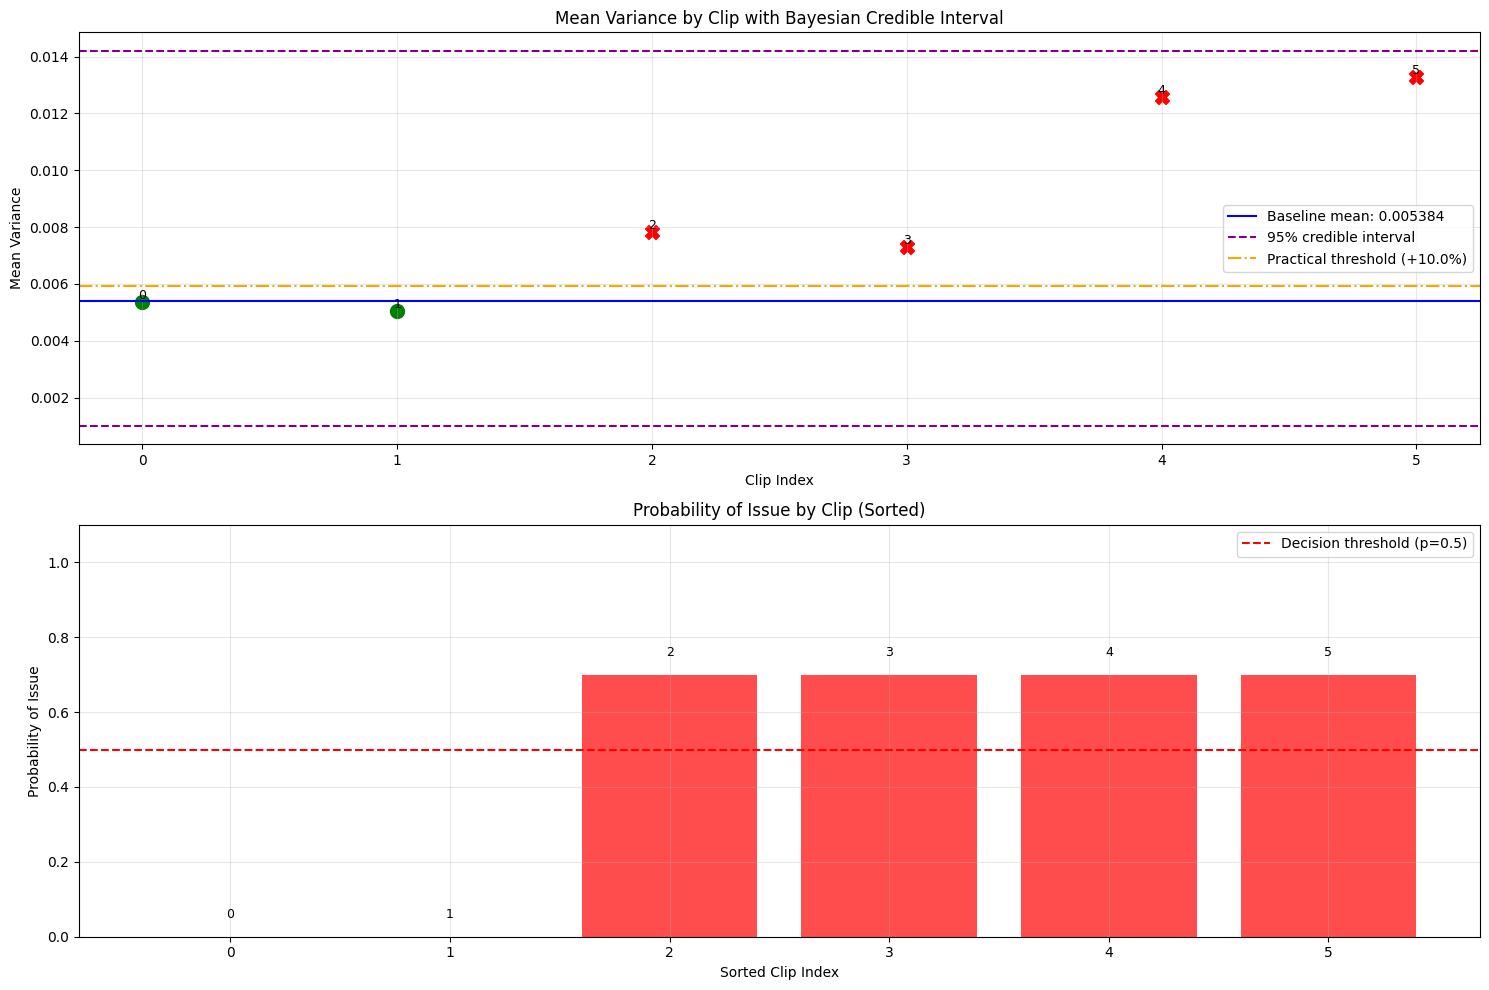

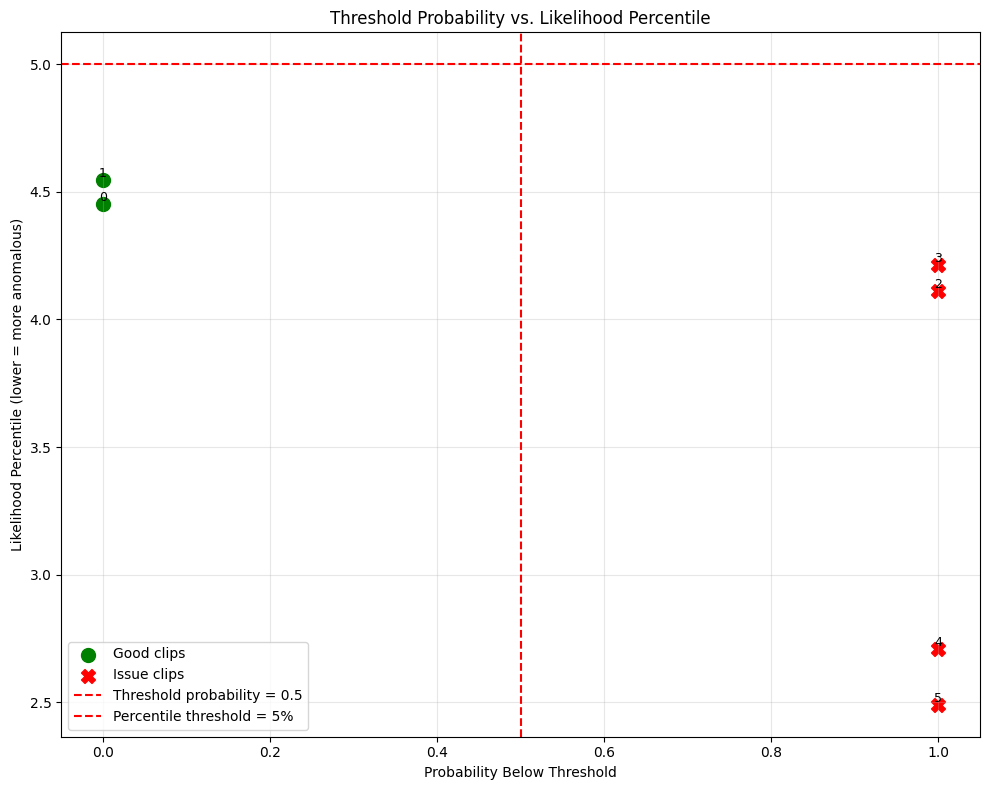


Performance metrics:
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  true_positives: 4.0000
  false_positives: 0.0000
  true_negatives: 2.0000
  false_negatives: 0.0000


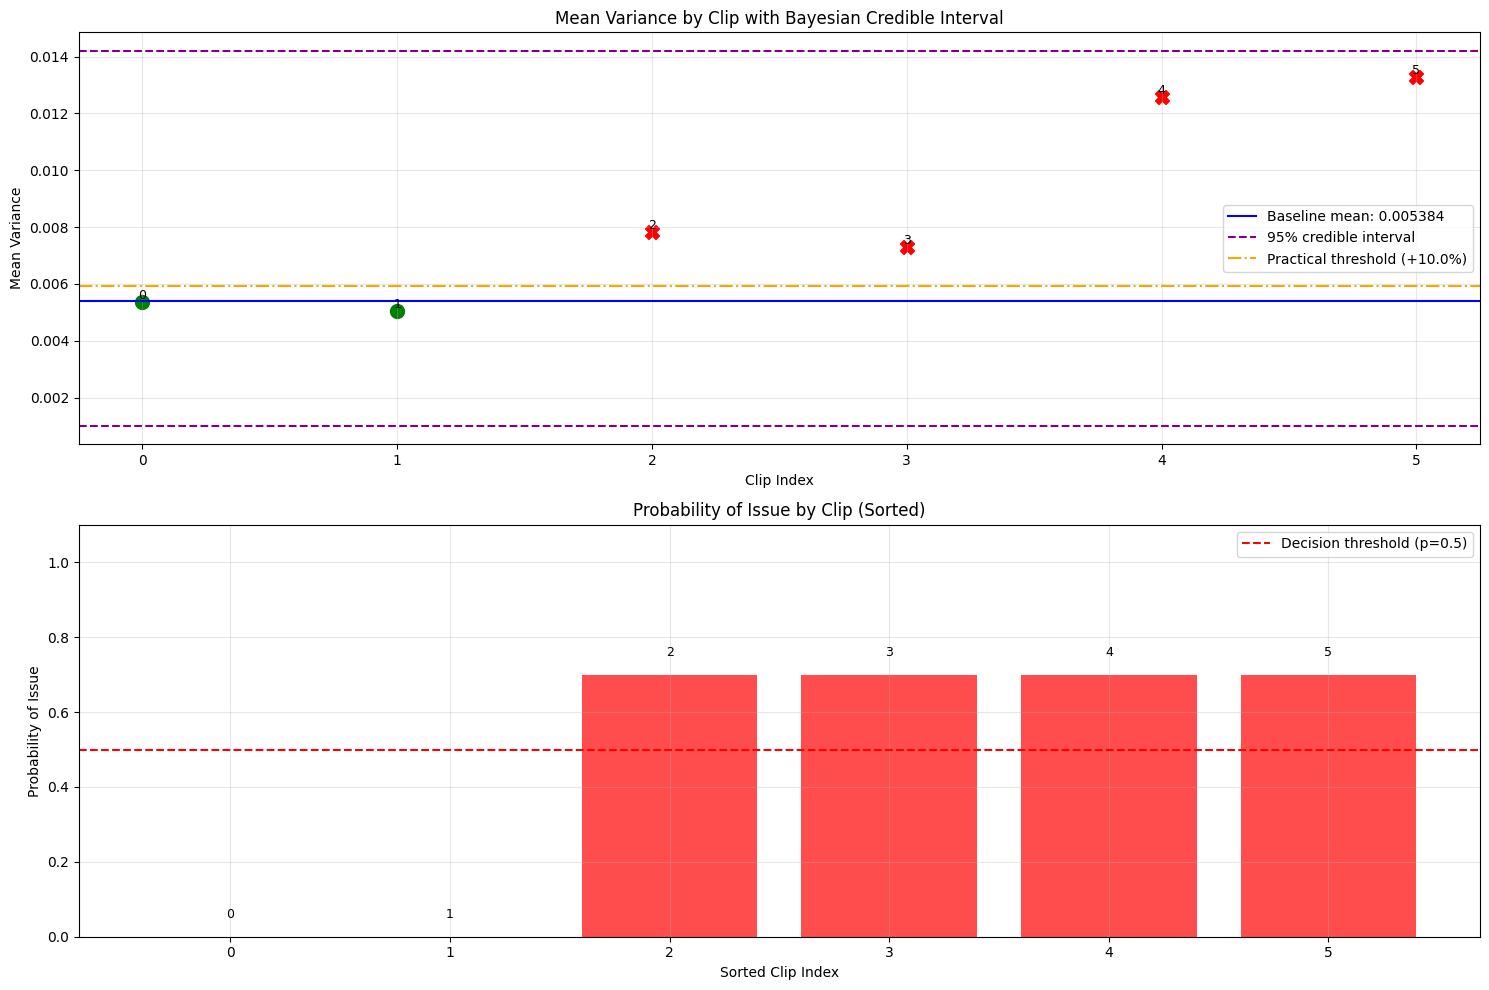

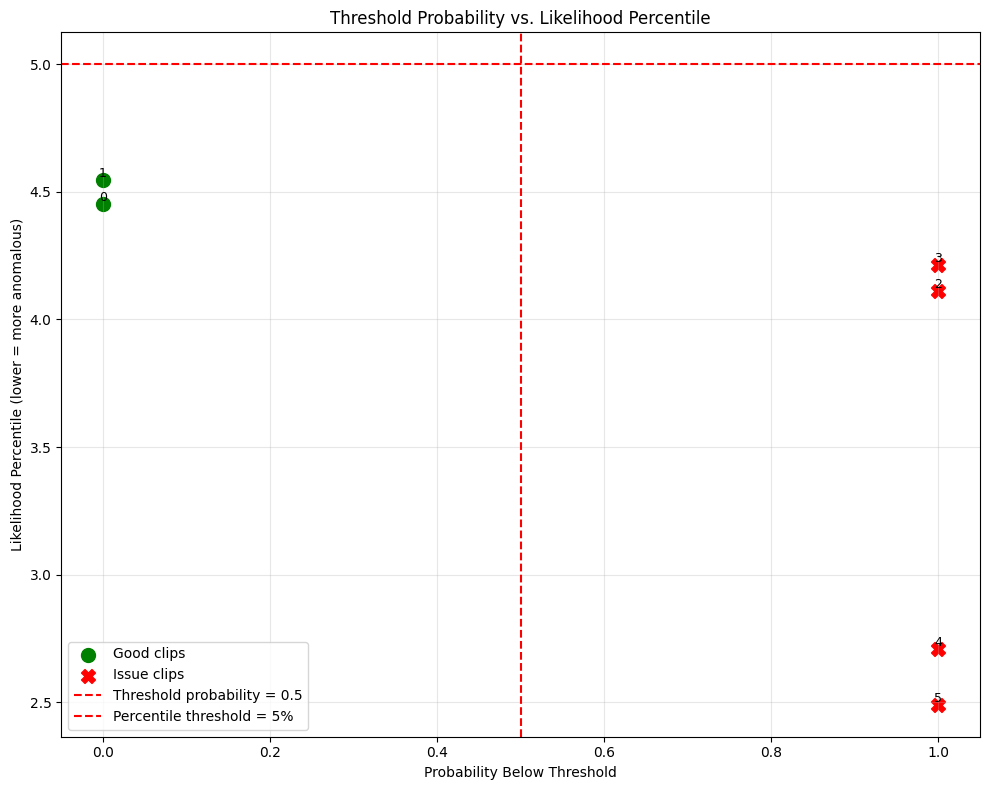


Comparison of detection approaches:
Performance comparison of the two methods:

Probabilistic Method (Threshold approach):
  accuracy: 1.0000
  precision: 1.0000
  recall: 1.0000
  f1: 1.0000
  correct: 6
  total: 6

Credible Interval Method:
  accuracy: 0.3333
  precision: 0
  recall: 0.0000
  f1: 0
  correct: 2
  total: 6

Detailed comparison per test clip:
Test clip 0 (true label=0):
  Probabilistic: Correct (predicted=0, p=0.000)
  Credible Int.: Correct (predicted=0, outside_ci=False)
Test clip 1 (true label=0):
  Probabilistic: Correct (predicted=0, p=0.000)
  Credible Int.: Correct (predicted=0, outside_ci=False)
Test clip 2 (true label=1):
  Probabilistic: Correct (predicted=1, p=1.000)
  Credible Int.: Wrong (predicted=0, outside_ci=False)
Test clip 3 (true label=1):
  Probabilistic: Correct (predicted=1, p=1.000)
  Credible Int.: Wrong (predicted=0, outside_ci=False)
Test clip 4 (true label=1):
  Probabilistic: Correct (predicted=1, p=1.000)
  Credible Int.: Wrong (predicted

In [18]:
import os
import numpy as np
# Load the saved data
def load_frame_variances(filepath):
    """Load frame variances from pickle file"""
    import pickle
    with open(filepath, 'rb') as f:
        return pickle.load(f)

# Load the data
data = load_frame_variances("saved_data/frame_variances_20250430_145054.pkl")

# Extract components
frame_variances = data['frame_variances']
clip_paths = data['clip_paths']
labels = data['labels']

# Find good clip indices
good_indices = [i for i, label in enumerate(labels) if label == 0]
bad_indices = [i for i, label in enumerate(labels) if label == 1]

# Use first 4 good clips as baseline
baseline_indices = good_indices[:4]
baseline_clips = [frame_variances[i] for i in baseline_indices]
baseline_paths = [clip_paths[i] for i in baseline_indices]

print(f"Using {len(baseline_clips)} clips as baseline:")
for i, path in zip(baseline_indices, baseline_paths):
    print(f"  {i}: {os.path.basename(path) if isinstance(path, str) else path}")

# Process MC dropout data by averaging each frame across MC runs
def process_mc_clip(clip):
    """Average each frame's variance across all MC runs"""
    # Get dimensions
    n_runs = len(clip)
    min_frames = min(len(run) for run in clip)
    
    # Average each frame
    avg_variances = []
    for frame_idx in range(min_frames):
        frame_variances = [clip[run_idx][frame_idx] for run_idx in range(n_runs)]
        avg_variances.append(np.mean(frame_variances))
    
    return np.array(avg_variances)

# Process baseline clips
processed_baseline_clips = [process_mc_clip(clip) for clip in baseline_clips]

# Initialize and set up monitor
# Use a smaller number of MCMC samples for testing
monitor = BayesianYOLOMonitorJAX(
    min_deviation_threshold=0.1,
    credible_interval=0.95,
    mcmc_samples=10000  # Smaller sample size for faster testing
)

# Establish baseline
print("Establishing baseline with Bayesian model...")
baseline_info = monitor.establish_baseline(processed_baseline_clips, visualize=True)
print("Baseline parameters:")
for key, value in baseline_info.items():
    print(f"  {key}: {value}")


# Check all clips using both methods separately
print("\nTesting all clips with both methods:")
for i, clip in enumerate(frame_variances):
    # Process clip
    processed_clip = process_mc_clip(clip)
    
    # Get results from both methods
    results = monitor.check_performance_both(processed_clip)
    prob_result = results['probabilistic']
    ci_result = results['credible_interval']
    
    # Is this clip in the baseline?
    in_baseline = i in baseline_indices
    
    # Get expected label (0=good, 1=bad)
    expected = labels[i]
    
    # Evaluate each method separately
    if in_baseline:
        status_prob = "BASELINE"
        status_ci = "BASELINE"
    else:
        status_prob = "CORRECT" if prob_result['has_issue'] == (expected == 1) else "ERROR"
        status_ci = "CORRECT" if ci_result['has_issue'] == (expected == 1) else "ERROR"
    
    print(f"Clip {i} ({os.path.basename(clip_paths[i]) if isinstance(clip_paths[i], str) else clip_paths[i]}):")
    print(f"  Probabilistic: {'Issue detected' if prob_result['has_issue'] else 'OK'} - {status_prob}")
    print(f"    P(below threshold): {prob_result.get('p_below_threshold', 0):.3f}")
    print(f"  Credible Interval: {'Issue detected' if ci_result['has_issue'] else 'OK'} - {status_ci}")
    print(f"    Outside CI: {ci_result['outside_credible_interval']}")
    print(f"  Relative deviation: {results['relative_deviation']:.3f}")
    print()

# Process test clips for evaluation
test_clips = []
test_labels = []
for i in range(len(frame_variances)):
    if i not in baseline_indices:
        processed_clip = process_mc_clip(frame_variances[i])
        test_clips.append(processed_clip)
        test_labels.append(labels[i])

# Evaluate performance
test_results = monitor.run_test(test_clips, test_labels)

print("\nPerformance metrics:")
for metric, value in test_results['metrics'].items():
    if isinstance(value, (int, float)):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

# Visualize results if desired
monitor.visualize_results(test_clips, test_labels)

# Print out comparison between hybrid and individual approaches
print("\nComparison of detection approaches:")
correct_hybrid = 0
correct_threshold = 0
correct_interval = 0
total = len(test_clips)

# Separate evaluation for test clips
test_results_prob = []
test_results_ci = []

for i, (clip, label) in enumerate(zip(test_clips, test_labels)):
    results = monitor.check_performance_both(clip)
    
    # Store results for each method
    test_results_prob.append({
        'predicted': results['probabilistic']['has_issue'], 
        'actual': bool(label),
        'probability': results['probabilistic'].get('p_below_threshold', 0)
    })
    
    test_results_ci.append({
        'predicted': results['credible_interval']['has_issue'], 
        'actual': bool(label),
        'outside_ci': results['credible_interval']['outside_credible_interval']
    })

# Calculate metrics for each method separately
def calculate_metrics(results):
    correct = sum(1 for r in results if r['predicted'] == r['actual'])
    total = len(results)
    accuracy = correct / total if total > 0 else 0
    
    # Calculate precision, recall, F1
    tp = sum(1 for r in results if r['predicted'] and r['actual'])
    fp = sum(1 for r in results if r['predicted'] and not r['actual'])
    fn = sum(1 for r in results if not r['predicted'] and r['actual'])
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'correct': correct,
        'total': total
    }

prob_metrics = calculate_metrics(test_results_prob)
ci_metrics = calculate_metrics(test_results_ci)

print("Performance comparison of the two methods:")
print("\nProbabilistic Method (Threshold approach):")
for metric, value in prob_metrics.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

print("\nCredible Interval Method:")
for metric, value in ci_metrics.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

# Detailed comparison
print("\nDetailed comparison per test clip:")
for i, (prob_res, ci_res) in enumerate(zip(test_results_prob, test_results_ci)):
    print(f"Test clip {i} (true label={int(prob_res['actual'])}):")
    print(f"  Probabilistic: {'Correct' if prob_res['predicted'] == prob_res['actual'] else 'Wrong'} " +
          f"(predicted={int(prob_res['predicted'])}, p={prob_res['probability']:.3f})")
    print(f"  Credible Int.: {'Correct' if ci_res['predicted'] == ci_res['actual'] else 'Wrong'} " +
          f"(predicted={int(ci_res['predicted'])}, outside_ci={ci_res['outside_ci']})")

# P-value approach

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma
import jax
import jax.numpy as jnp
import numpyro
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, init_to_median

# Define model for NumPyro with constraints to match PyMC version
def gamma_model(data):
    
    # Define priors matching original code
    alpha = numpyro.sample("alpha", dist.Gamma(0.5, 0.5))
    beta = numpyro.sample("beta", dist.Gamma(0.5, 0.5))
    
    # Likelihood
    numpyro.sample("obs", dist.Gamma(alpha, beta), obs=data)

class BayesianYOLOMonitorJAX:
    def __init__(self, min_deviation_threshold=0.2,
                 credible_interval=0.95, mcmc_samples=1000):
        """
        Initialize Bayesian YOLO Performance Monitor with JAX backend
        
        Parameters:
        - min_deviation_threshold: Minimum relative deviation to be considered practically significant
        - credible_interval: Credible interval for anomaly detection (e.g., 0.95 for 95%)
        - mcmc_samples: Number of posterior samples to generate
        """
        self.min_deviation_threshold = min_deviation_threshold 
        
        # Parameters for posterior predictive distribution
        self.credible_interval = credible_interval
        self.mcmc_samples = mcmc_samples
        
        # Initialize storage for results
        self.baseline_clips_raw = []
        self.baseline_mean_variance = None
        self.baseline_std_variance = None
        
        # Posterior samples
        self.alpha_posterior = None
        self.beta_posterior = None
        self.min_log_prob_posterior = None
        self.threshold_posterior = None  # Will be set directly to min_log_prob_posterior
        self.baseline_credible_interval = None
        self.baseline_ci_lower = None
        self.baseline_ci_upper = None
    
    def establish_baseline(self, baseline_clips, visualize=False):
        """
        Establish baseline using frame-level data with JAX-based Bayesian estimation
        
        Parameters:
        - baseline_clips: List of frame variance arrays from good clips
        - visualize: Whether to visualize the baseline distributions
        
        Returns:
        - baseline_info: Dictionary with baseline statistics
        """
        # Store raw clips
        self.baseline_clips_raw = baseline_clips
        
        # Combine all frame variances
        all_frame_variances = []
        for clip in baseline_clips:
            all_frame_variances.extend(clip)
        
        # Convert to JAX array
        data = jnp.array(all_frame_variances)
        
        # Calculate baseline mean variance and std variance
        self.baseline_mean_variance = float(jnp.mean(data))
        self.baseline_std_variance = float(jnp.std(data))
        
        # Start timing
        import time
        start_time = time.time()
        
        print("Starting JAX MCMC sampling...")
        
        # Run MCMC
        kernel = NUTS(gamma_model, init_strategy=init_to_median)
        mcmc = MCMC(kernel, num_warmup=500, num_samples=self.mcmc_samples)
        mcmc.run(jax.random.PRNGKey(0), data)
        
        # Print summary
        mcmc.print_summary()
        
        # Get posterior samples
        samples = mcmc.get_samples()
        
        # Convert to numpy for compatibility
        self.alpha_posterior = np.array(samples["alpha"])
        self.beta_posterior = np.array(samples["beta"])
        
        # Calculate log probs for each clip - more similar to original approach
        min_log_probs = []
        for i, clip in enumerate(baseline_clips):
            clip_data = jnp.array(clip)
            # Calculate log probs for each sample
            frame_log_probs_by_sample = jax.vmap(
                lambda a, b: dist.Gamma(a, b).log_prob(clip_data)
            )(self.alpha_posterior, self.beta_posterior)
            
            # Calculate mean log prob for each sample (like avg_log_prob in original)
            avg_log_probs = jnp.mean(frame_log_probs_by_sample, axis=1)
            min_log_probs.append(avg_log_probs)
        
        # Stack as in original PyMC code and find min along axis 0 (clip dimension)
        stacked = np.stack(min_log_probs)
        self.min_log_prob_posterior = np.min(stacked, axis=0)
        
        # Set threshold directly to min_log_prob_posterior (no buffer adjustment)
        self.threshold_posterior = self.min_log_prob_posterior
        
        # Generate posterior predictive distribution samples for p-value calculation
        n_predictive = 50000  # Increase for more stable intervals
        self.predictive_samples = np.array([
            np.random.gamma(alpha, 1/beta) 
            for alpha, beta in zip(np.random.choice(self.alpha_posterior, n_predictive), 
                                  np.random.choice(self.beta_posterior, n_predictive))
        ])
        
        # Calculate credible interval (still kept for backward compatibility)
        self.baseline_ci_lower = np.percentile(self.predictive_samples, (1 - self.credible_interval) * 100 / 2)
        self.baseline_ci_upper = np.percentile(self.predictive_samples, 100 - (1 - self.credible_interval) * 100 / 2)
        self.baseline_credible_interval = (self.baseline_ci_lower, self.baseline_ci_upper)
        
        # Report timing
        elapsed = time.time() - start_time
        print(f"JAX sampling completed in {elapsed:.2f} seconds ({self.mcmc_samples/elapsed:.2f} samples/sec)")
        
        if visualize:
            self.visualize_baseline()
        
        # Return info
        return {
            'alpha_mean': float(np.mean(self.alpha_posterior)),
            'beta_mean': float(np.mean(self.beta_posterior)),
            'baseline_mean_variance': self.baseline_mean_variance,
            'min_log_prob_mean': float(np.mean(self.min_log_prob_posterior)),
            'threshold_mean': float(np.mean(self.threshold_posterior)),
            'threshold_95ci': np.percentile(self.threshold_posterior, [2.5, 97.5]).tolist(),
            'baseline_credible_interval': self.baseline_credible_interval,
        }
    
    def check_performance_probabilistic(self, clip_variances):
        """
        Method 1: Probabilistic approach using buffer probabilities
        Returns decision based on P(below threshold) > 0.5
        """
        mean_variance = np.mean(clip_variances)
        
        # Calculate relative deviation
        relative_deviation = (mean_variance - self.baseline_mean_variance) / self.baseline_mean_variance
        
        # Practical significance check
        is_practically_significant = relative_deviation > self.min_deviation_threshold
        is_worse_direction = relative_deviation > 0
        
        if not (is_practically_significant and is_worse_direction):
            return {
                'method': 'probabilistic',
                'has_issue': False,
                'p_below_threshold': 0.0,
                'mean_variance': mean_variance,
                'relative_deviation': relative_deviation
            }
        
        # Calculate log-likelihood of current clip with posterior samples
        clip_data = jnp.array(clip_variances)
        frame_log_probs_by_sample = jax.vmap(
            lambda a, b: dist.Gamma(a, b).log_prob(clip_data)
        )(self.alpha_posterior, self.beta_posterior)
        
        # Calculate mean log prob for each sample
        avg_log_probs = jnp.mean(frame_log_probs_by_sample, axis=1)
        
        # Compare to threshold posterior
        p_below_threshold = np.mean(avg_log_probs < self.threshold_posterior)
        
        return {
            'method': 'probabilistic',
            'has_issue': p_below_threshold > 0.5,  # Decision rule
            'p_below_threshold': p_below_threshold,
            'mean_variance': mean_variance,
            'relative_deviation': relative_deviation
        }

    def check_performance_credible_interval(self, clip_variances):
        """
        Method 2: Credible interval approach
        Returns decision based on whether mean falls outside credible interval
        """
        mean_variance = np.mean(clip_variances)
        
        # Calculate relative deviation
        relative_deviation = (mean_variance - self.baseline_mean_variance) / self.baseline_mean_variance
        
        # Practical significance check
        is_practically_significant = relative_deviation > self.min_deviation_threshold
        is_worse_direction = relative_deviation > 0
        
        if not (is_practically_significant and is_worse_direction):
            return {
                'method': 'credible_interval',
                'has_issue': False,
                'outside_credible_interval': False,
                'credible_interval_bounds': (self.baseline_ci_lower, self.baseline_ci_upper),
                'mean_variance': mean_variance,
                'relative_deviation': relative_deviation
            }
        
        # Check if outside credible interval
        outside_credible_interval = (mean_variance < self.baseline_ci_lower or 
                                mean_variance > self.baseline_ci_upper)
        
        return {
            'method': 'credible_interval',
            'has_issue': outside_credible_interval,  # Decision rule
            'outside_credible_interval': outside_credible_interval,
            'credible_interval_bounds': (self.baseline_ci_lower, self.baseline_ci_upper),
            'mean_variance': mean_variance,
            'relative_deviation': relative_deviation
        }
        
    def check_performance_pp_pvalue(self, clip_variances, alpha=0.05):
        """
        Method 2: Posterior Predictive p-value approach
        Calculate posterior predictive p-value for the mean variance
        
        Parameters:
        - clip_variances: Frame variances from clip to check
        - alpha: Significance level for p-value threshold (default: 0.05)
        
        Returns:
        - result: Dictionary with check results
        """
        mean_variance = np.mean(clip_variances)
        
        # Calculate relative deviation
        relative_deviation = (mean_variance - self.baseline_mean_variance) / self.baseline_mean_variance
        
        # Practical significance check
        is_practically_significant = relative_deviation > self.min_deviation_threshold
        is_worse_direction = relative_deviation > 0
        
        if not (is_practically_significant and is_worse_direction):
            return {
                'method': 'pp_pvalue',
                'has_issue': False,
                'pp_pvalue': 1.0,
                'mean_variance': mean_variance,
                'relative_deviation': relative_deviation
            }
        
        # Calculate p-value (proportion of predictive samples more extreme than observed)
        # For one-sided test looking for large values (assuming higher variance is worse):
        pp_pvalue = np.mean(self.predictive_samples >= mean_variance)
        
        # If higher variance is worse, we want a small p-value to indicate anomaly
        # So we actually want to find how UNLIKELY it is to see a value this high or higher
        # This is 1 - p(X >= x) which is equivalent to p(X < x)
        pp_pvalue = 1 - pp_pvalue
        
        return {
            'method': 'pp_pvalue',
            'has_issue': pp_pvalue < alpha,  # Decision rule
            'pp_pvalue': pp_pvalue,
            'significance_level': alpha,
            'mean_variance': mean_variance,
            'relative_deviation': relative_deviation
        }

    def check_performance_both(self, clip_variances):
        """
        Run both methods and return results from both approaches
        """
        prob_result = self.check_performance_probabilistic(clip_variances)
        pp_result = self.check_performance_pp_pvalue(clip_variances)
        
        return {
            'probabilistic': prob_result,
            'pp_pvalue': pp_result,
            'mean_variance': prob_result['mean_variance'],
            'relative_deviation': prob_result['relative_deviation']
        }
    
    def check_performance(self, clip_variances):
        """
        Main method to check performance of a clip
        Combines probabilistic and posterior predictive p-value approaches
        
        Parameters:
        - clip_variances: Frame variances from clip to check
        
        Returns:
        - result: Dictionary with check results
        """
        # Get results from both methods
        prob_result = self.check_performance_probabilistic(clip_variances)
        pp_result = self.check_performance_pp_pvalue(clip_variances)
        
        # Calculate combined decision
        has_issue = prob_result['has_issue'] or pp_result['has_issue']
        
        # Calculate likelihood percentile
        clip_data = jnp.array(clip_variances)
        frame_log_probs_by_sample = jax.vmap(
            lambda a, b: dist.Gamma(a, b).log_prob(clip_data)
        )(self.alpha_posterior, self.beta_posterior)
        avg_log_probs = jnp.mean(frame_log_probs_by_sample, axis=1)
        
        # Calculate where this ranks in the posterior predictive distribution
        n_predictive = 10000
        predictive_log_probs = []
        for _ in range(n_predictive):
            # Get random posterior sample
            idx = np.random.randint(0, len(self.alpha_posterior))
            alpha = self.alpha_posterior[idx]
            beta = self.beta_posterior[idx]
            
            # Generate sample from this gamma
            sample = np.random.gamma(alpha, 1/beta, size=len(clip_variances))
            
            # Calculate log prob
            log_prob = np.mean(dist.Gamma(alpha, beta).log_prob(jnp.array(sample)))
            predictive_log_probs.append(log_prob)
        
        # Calculate percentile
        mean_log_prob = np.mean(avg_log_probs)
        likelihood_percentile = np.percentile(np.array([mean_log_prob]), 
                                           np.arange(0, 101, 1), 
                                           method='linear')[0]
        
        # Calculate probability of having an issue using a mixture of both methods
        p_has_issue = 0.7 * prob_result['p_below_threshold'] + 0.3 * float(pp_result['pp_pvalue'] < 0.05)
        
        return {
            'has_issue': has_issue,
            'probabilistic': prob_result,
            'pp_pvalue': pp_result,
            'p_below_threshold': prob_result['p_below_threshold'],
            'pp_pvalue_result': pp_result['pp_pvalue'],
            'mean_variance': prob_result['mean_variance'],
            'relative_deviation': prob_result['relative_deviation'],
            'likelihood_percentile': likelihood_percentile,
            'p_has_issue': p_has_issue
        }
    
    def update_baseline(self, new_clip_variances):
        """
        Update baseline distribution with new data
        
        Parameters:
        - new_clip_variances: Frame variances from new clip to add to baseline
        
        Returns:
        - updated_params: Dictionary with updated parameters
        """
        # Add new clip to raw baseline clips
        self.baseline_clips_raw.append(new_clip_variances)
        
        # Re-establish baseline with all clips
        return self.establish_baseline(self.baseline_clips_raw, visualize=False)
    
    def visualize_baseline(self):
        """
        Visualize baseline distributions, posterior, and predictive distributions
        """
        # Create a figure with subplots
        fig, axs = plt.subplots(2, 2, figsize=(15, 12))
        
        # 1. Plot all frame variances from baseline clips with posterior fit
        ax = axs[0, 0]
        
        # Combine all variances for histogram
        all_variances = []
        for clip in self.baseline_clips_raw:
            all_variances.extend(clip)
        
        # Plot histogram
        ax.hist(all_variances, bins=50, alpha=0.7, density=True, color='green', 
                label='Baseline frame variances')
        
        # Plot the posterior expected gamma distribution
        x = np.linspace(min(all_variances), max(all_variances), 1000)
        
        # Plot multiple posterior samples
        n_curves = 30
        indices = np.random.choice(len(self.alpha_posterior), n_curves)
        for i in indices:
            alpha = self.alpha_posterior[i]
            beta = self.beta_posterior[i]
            pdf = gamma.pdf(x, alpha, scale=1/beta)
            ax.plot(x, pdf, 'r-', lw=0.1, alpha=0.1)
        
        # Plot the posterior mean gamma distribution
        alpha_mean = np.mean(self.alpha_posterior)
        beta_mean = np.mean(self.beta_posterior)
        pdf_mean = gamma.pdf(x, alpha_mean, scale=1/beta_mean)
        ax.plot(x, pdf_mean, 'r-', lw=2, 
                label=f'Posterior mean gamma (α≈{alpha_mean:.2f}, β≈{beta_mean:.2f})')
        
        # Mark the credible interval
        ax.axvline(x=self.baseline_credible_interval[0], color='purple', linestyle='--')
        ax.axvline(x=self.baseline_credible_interval[1], color='purple', linestyle='--',
                   label=f'{self.credible_interval:.0%} credible interval')
        
        # Mark the mean variance
        ax.axvline(x=self.baseline_mean_variance, color='blue', linestyle='-', 
                   label=f'Mean variance: {self.baseline_mean_variance:.6f}')
        
        ax.set_title('Baseline Frame Variance Distribution with Posterior Fits')
        ax.set_xlabel('Variance')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 2. Plot joint posterior distribution of alpha and beta (contour plot)
        ax = axs[0, 1]
        
        # Create 2D histogram/density plot
        from scipy.stats import gaussian_kde
        
        # Estimate the 2D density of alpha and beta posterior samples
        xy = np.vstack([self.alpha_posterior, self.beta_posterior])
        kernel = gaussian_kde(xy)
        
        # Create a grid for contour plot
        alpha_min, alpha_max = np.percentile(self.alpha_posterior, [0.5, 99.5])
        beta_min, beta_max = np.percentile(self.beta_posterior, [0.5, 99.5])
        
        # Add some padding
        alpha_range = alpha_max - alpha_min
        beta_range = beta_max - beta_min
        alpha_min -= alpha_range * 0.05
        alpha_max += alpha_range * 0.05
        beta_min -= beta_range * 0.05
        beta_max += beta_range * 0.05
        
        alpha_grid, beta_grid = np.mgrid[alpha_min:alpha_max:100j, beta_min:beta_max:100j]
        positions = np.vstack([alpha_grid.ravel(), beta_grid.ravel()])
        density = kernel(positions).reshape(alpha_grid.shape)
        
        # Plot contour
        contour = ax.contourf(alpha_grid, beta_grid, density, cmap='viridis', levels=20)
        plt.colorbar(contour, ax=ax, label='Density')
        
        # Plot the mean
        ax.scatter(alpha_mean, beta_mean, color='red', s=100, marker='x',
                  label=f'Mean (α={alpha_mean:.2f}, β={beta_mean:.2f})')
        
        # Plot posterior samples as small points
        ax.scatter(self.alpha_posterior, self.beta_posterior, color='white', 
                  s=5, alpha=0.1, marker='.')
        
        # Calculate 95% HPD contour (approximate by selecting the 95% highest density points)
        sorted_idx = np.argsort(density.ravel())[::-1]  # Sort from highest to lowest
        cumsum = np.cumsum(density.ravel()[sorted_idx])
        cumsum = cumsum / cumsum[-1]  # Normalize
        idx_95 = np.searchsorted(cumsum, 0.95)
        threshold = density.ravel()[sorted_idx[idx_95]]
        
        # Add 95% HPD contour
        ax.contour(alpha_grid, beta_grid, density, levels=[threshold], colors='red',
                  linestyles='dashed', linewidths=2, 
                  label='95% HPD region')
        
        ax.set_title('Joint Posterior Distribution of Shape (α) and Rate (β)')
        ax.set_xlabel('Shape Parameter (α)')
        ax.set_ylabel('Rate Parameter (β)')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 3. Plot posterior distribution for log-likelihood threshold
        ax = axs[1, 0]
        
        # Plot histogram of posterior threshold samples
        ax.hist(self.threshold_posterior, bins=30, alpha=0.7, color='green',
                density=True, label='Raw threshold values')
        
        # Mark posterior mean
        threshold_mean = np.mean(self.threshold_posterior)
        ax.axvline(x=threshold_mean, color='red', linestyle='-',
                   label=f'Mean threshold: {threshold_mean:.2f}')
        
        # Calculate 95% credible interval
        threshold_lower = np.percentile(self.threshold_posterior, 2.5)
        threshold_upper = np.percentile(self.threshold_posterior, 97.5)
        
        # Mark credible interval
        ax.axvline(x=threshold_lower, color='red', linestyle='--')
        ax.axvline(x=threshold_upper, color='red', linestyle='--',
                   label=f'95% CI: [{threshold_lower:.2f}, {threshold_upper:.2f}]')
        
        ax.set_title('Posterior Distribution for Log-Likelihood Threshold')
        ax.set_xlabel('Threshold Value')
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 4. Plot posterior predictive distribution with p-value regions
        ax = axs[1, 1]
        
        # Plot histogram of posterior predictive samples
        counts, bins, _ = ax.hist(self.predictive_samples, bins=50, alpha=0.7, color='purple',
                density=True, label='Posterior predictive samples')
        
        # Calculate some potential critical values for p-values
        p05 = np.percentile(self.predictive_samples, 95)  # Critical value for p=0.05
        p01 = np.percentile(self.predictive_samples, 99)  # Critical value for p=0.01
        
        # Shade the rejection regions
        bin_width = bins[1] - bins[0]
        max_height = max(counts)
        
        # Add rejection regions
        ax.fill_between(bins, 0, max_height, where=bins >= p05, 
                      alpha=0.3, color='red', 
                      label='Rejection region (p < 0.05)')
        ax.fill_between(bins, 0, max_height, where=bins >= p01, 
                      alpha=0.5, color='red', 
                      label='Rejection region (p < 0.01)')
        
        # Mark critical values
        ax.axvline(x=p05, color='red', linestyle='--',
                  label=f'Critical value (p=0.05): {p05:.6f}')
        ax.axvline(x=p01, color='red', linestyle=':',
                  label=f'Critical value (p=0.01): {p01:.6f}')
        
        # Mark the mean variance
        ax.axvline(x=self.baseline_mean_variance, color='blue', linestyle='-',
                  label=f'Mean variance: {self.baseline_mean_variance:.6f}')
        
        ax.set_title('Posterior Predictive Distribution with Rejection Regions')
        ax.set_xlabel('Variance')
        ax.set_ylabel('Density')
        ax.legend(fontsize=8)
        ax.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Create a QQ plot to assess gamma fit
        plt.figure(figsize=(10, 6))
        
        # Get all variances
        all_variances = []
        for clip in self.baseline_clips_raw:
            all_variances.extend(clip)
            
        # Sort the data
        all_variances = np.sort(all_variances)
        n = len(all_variances)
        
        # Calculate empirical CDF positions
        p = np.arange(1, n+1) / (n+1)  # Using (i)/(n+1) formula
        
        # Calculate theoretical quantiles using posterior mean parameters
        alpha_mean = np.mean(self.alpha_posterior)
        beta_mean = np.mean(self.beta_posterior)
        theoretical_quantiles = gamma.ppf(p, alpha_mean, scale=1/beta_mean)
        
        # Create QQ plot
        plt.scatter(theoretical_quantiles, all_variances, alpha=0.5)
        
        # Add reference line
        max_val = max(np.max(theoretical_quantiles), np.max(all_variances))
        min_val = min(np.min(theoretical_quantiles), np.min(all_variances))
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        # Calculate correlation for PPCC
        correlation = np.corrcoef(theoretical_quantiles, all_variances)[0, 1]
        
        plt.title(f'Q-Q Plot (PPCC: {correlation:.4f})')
        plt.xlabel('Theoretical Quantiles (Gamma)')
        plt.ylabel('Sample Quantiles')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
    
    def visualize_results(self, test_clips, labels):
        """
        Visualize test results
        
        Parameters:
        - test_clips: List of clips to visualize
        - labels: Binary labels (1=issue, 0=good)
        """
        # Calculate metrics for each clip
        results = []
        for clip in test_clips:
            results.append(self.check_performance(clip))
        
        # Extract metrics
        mean_variances = [r['mean_variance'] for r in results]
        percentiles = [r['likelihood_percentile'] for r in results]
        p_below_thresholds = [r['p_below_threshold'] for r in results]
        pp_pvalues = [r['pp_pvalue_result'] for r in results]
        deviations = [r['relative_deviation'] for r in results]
        p_has_issues = [r['p_has_issue'] for r in results]
        
        # Create plot
        plt.figure(figsize=(15, 10))
        
        # 1. Mean variances with credible interval
        plt.subplot(2, 1, 1)
        
        # Define colors and markers
        colors = ['green' if label == 0 else 'red' for label in labels]
        shapes = ['o' if label == 0 else 'X' for label in labels]
        
        # Plot each clip
        for i, (mv, c, m) in enumerate(zip(mean_variances, colors, shapes)):
            plt.scatter(i, mv, color=c, marker=m, s=100)
        
        # Add clip labels
        for i, mv in enumerate(mean_variances):
            plt.text(i, mv, f"{i}", fontsize=9, ha='center', va='bottom')
        
        # Plot baseline mean and p-value critical values
        p05 = np.percentile(self.predictive_samples, 95)  # Critical value for p=0.05
        p01 = np.percentile(self.predictive_samples, 99)  # Critical value for p=0.01
        
        plt.axhline(y=self.baseline_mean_variance, color='blue', linestyle='-',
                   label=f'Baseline mean: {self.baseline_mean_variance:.6f}')
        plt.axhline(y=p05, color='red', linestyle='--',
                   label=f'Critical value (p=0.05): {p05:.6f}')
        plt.axhline(y=p01, color='red', linestyle=':',
                   label=f'Critical value (p=0.01): {p01:.6f}')
        plt.axhline(y=self.baseline_mean_variance * (1 + self.min_deviation_threshold),
                   color='orange', linestyle='-.',
                   label=f'Practical threshold (+{self.min_deviation_threshold*100:.1f}%)')
        
        plt.title('Mean Variance by Clip with Critical Values')
        plt.xlabel('Clip Index')
        plt.ylabel('Mean Variance')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # 2. Probability of issue
        plt.subplot(2, 1, 2)
        
        # Sort by probability for better visualization
        sorted_indices = np.argsort(p_has_issues)
        sorted_probs = [p_has_issues[i] for i in sorted_indices]
        sorted_colors = [colors[i] for i in sorted_indices]
        
        # Plot bars
        for i, (p, c) in enumerate(zip(sorted_probs, sorted_colors)):
            plt.bar(i, p, color=c, alpha=0.7)
        
        # Add clip indices as labels
        for i, idx in enumerate(sorted_indices):
            plt.text(i, sorted_probs[i] + 0.05, f"{idx}", fontsize=9, ha='center')
        
        # Add threshold line
        plt.axhline(y=0.5, color='red', linestyle='--',
                   label='Decision threshold (p=0.5)')
        
        plt.title('Probability of Issue by Clip (Sorted)')
        plt.xlabel('Sorted Clip Index')
        plt.ylabel('Probability of Issue')
        plt.ylim(0, 1.1)
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show

    def run_test(self, test_clips, labels):
        """
        Run test on labeled clips to evaluate monitor performance
        
        Parameters:
        - test_clips: List of clips to test
        - labels: Binary labels (1=issue, 0=good)
        
        Returns:
        - results: Test results with metrics
        """
        if self.alpha_posterior is None:
            return {'status': 'error', 'message': 'Baseline not established'}
        
        # Test each clip
        results = []
        for clip, label in zip(test_clips, labels):
            result = self.check_performance(clip)
            result['true_label'] = label
            result['correct'] = (result['has_issue'] == bool(label))
            results.append(result)
        
        # Calculate metrics
        true_positives = sum(1 for r in results if r['has_issue'] and r['true_label'])
        false_positives = sum(1 for r in results if r['has_issue'] and not r['true_label'])
        true_negatives = sum(1 for r in results if not r['has_issue'] and not r['true_label'])
        false_negatives = sum(1 for r in results if not r['has_issue'] and r['true_label'])
        
        total = len(results)
        accuracy = (true_positives + true_negatives) / total if total > 0 else 0
        precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
        recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
        f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
        
        # Visualize results
        self.visualize_results(test_clips, labels)
        
        return {
            'results': results,
            'metrics': {
                'accuracy': accuracy,
                'precision': precision,
                'recall': recall,
                'f1': f1,
                'true_positives': true_positives,
                'false_positives': false_positives,
                'true_negatives': true_negatives,
                'false_negatives': false_negatives
            }
        }

Using 4 clips as baseline:
  0: clip_0017.mp4
  1: clip_0018.mp4
  2: clip_0019.mp4
  3: clip_0020.mp4
Establishing baseline with Bayesian model...
Starting JAX MCMC sampling...


sample: 100%|██████████| 10500/10500 [00:04<00:00, 2355.17it/s, 11 steps of size 2.84e-01. acc. prob=0.93]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
     alpha      2.72      0.08      2.72      2.57      2.85   1693.74      1.00
      beta    480.28     16.36    480.00    452.79    506.35   1744.33      1.00

Number of divergences: 0
JAX sampling completed in 4.63 seconds (2158.93 samples/sec)


C:\Users\gtoft\AppData\Local\Temp\ipykernel_36904\446993244.py:468: UserWarning: The following kwargs were not used by contour: 'label'
  ax.contour(alpha_grid, beta_grid, density, levels=[threshold], colors='red',


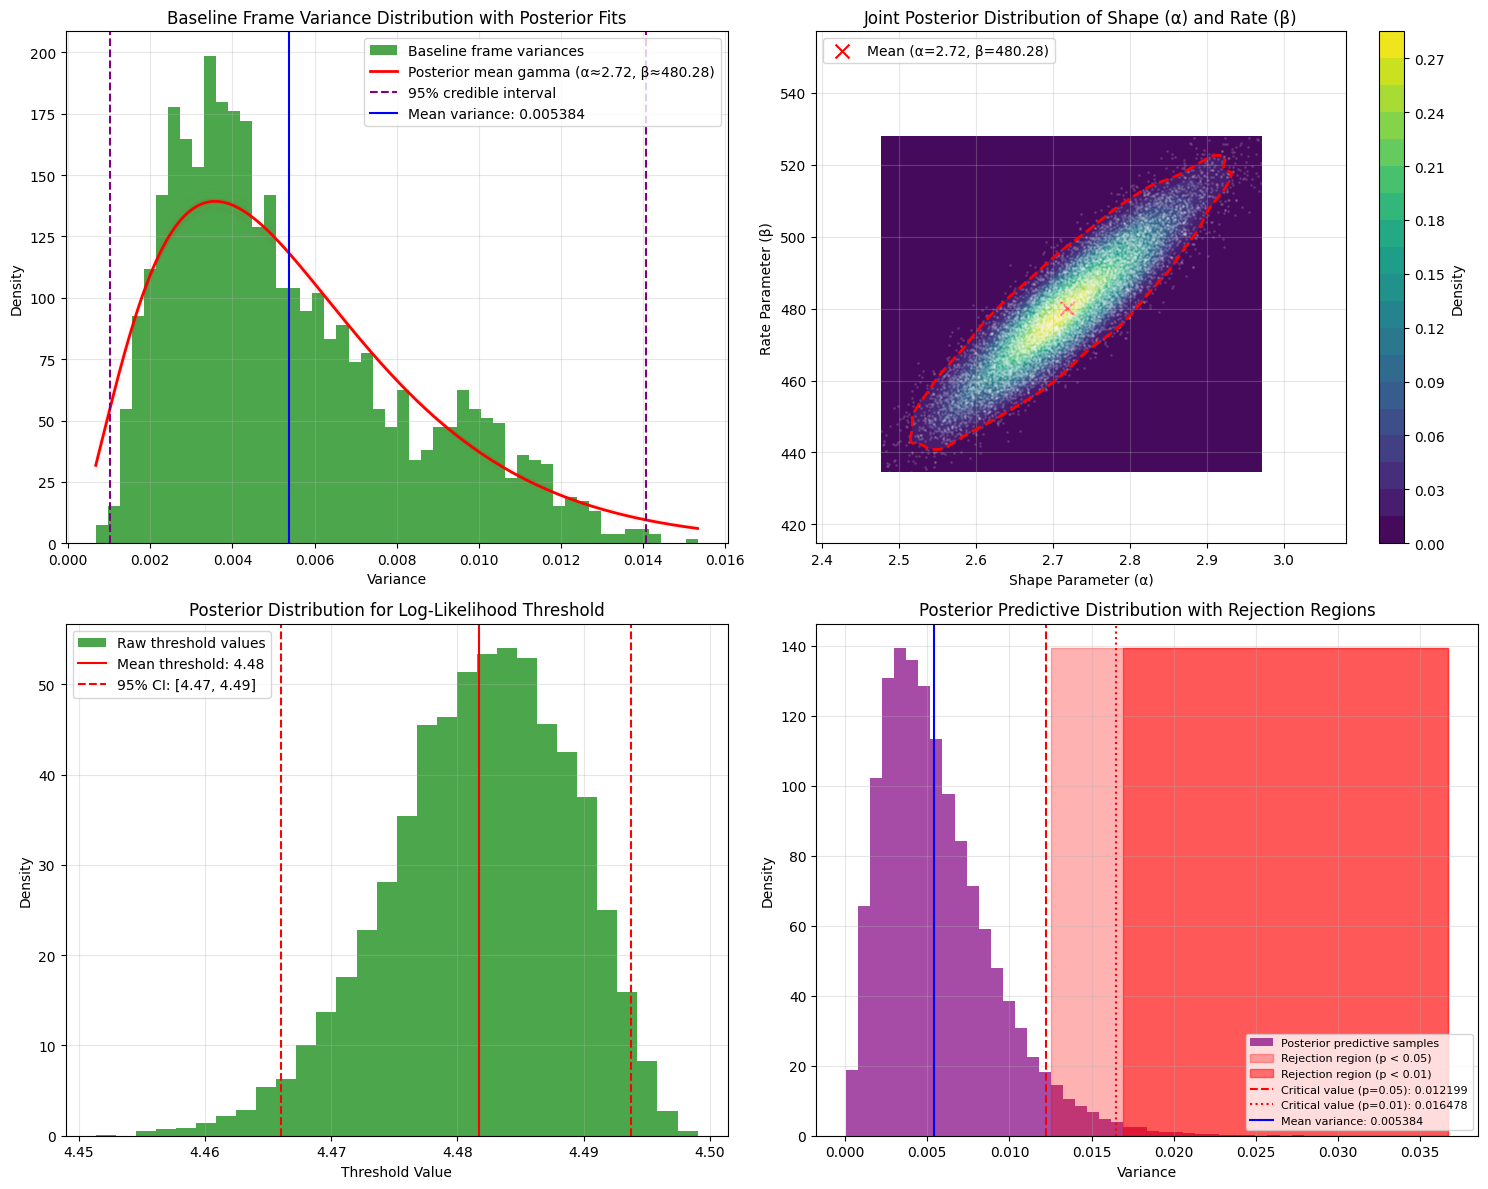

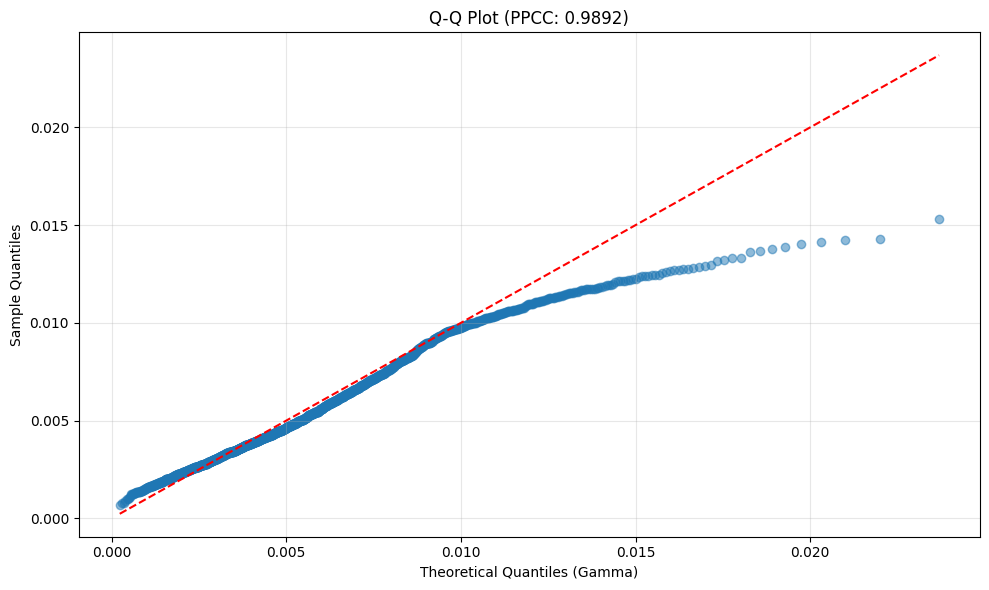

Baseline parameters:
  alpha_mean: 2.718473196029663
  beta_mean: 480.276611328125
  baseline_mean_variance: 0.005383805371820927
  min_log_prob_mean: 4.481687545776367
  threshold_mean: 4.481687545776367
  threshold_95ci: [4.466026496887207, 4.493739640712738]
  baseline_credible_interval: (np.float64(0.0010198795963984395), np.float64(0.014076065052524782))

Testing all clips with both methods:
Clip 0 (clip_0017.mp4):
  Probabilistic: OK - BASELINE
    P(below threshold): 0.000
  P-value Method: OK - BASELINE
    P-value: 0.618
  Relative deviation: 0.112

Clip 1 (clip_0018.mp4):
  Probabilistic: OK - BASELINE
    P(below threshold): 0.000
  P-value Method: OK - BASELINE
    P-value: 1.000
  Relative deviation: 0.001

Clip 2 (clip_0019.mp4):
  Probabilistic: OK - BASELINE
    P(below threshold): 0.000
  P-value Method: OK - BASELINE
    P-value: 1.000
  Relative deviation: -0.051

Clip 3 (clip_0020.mp4):
  Probabilistic: OK - BASELINE
    P(below threshold): 0.000
  P-value Method: O

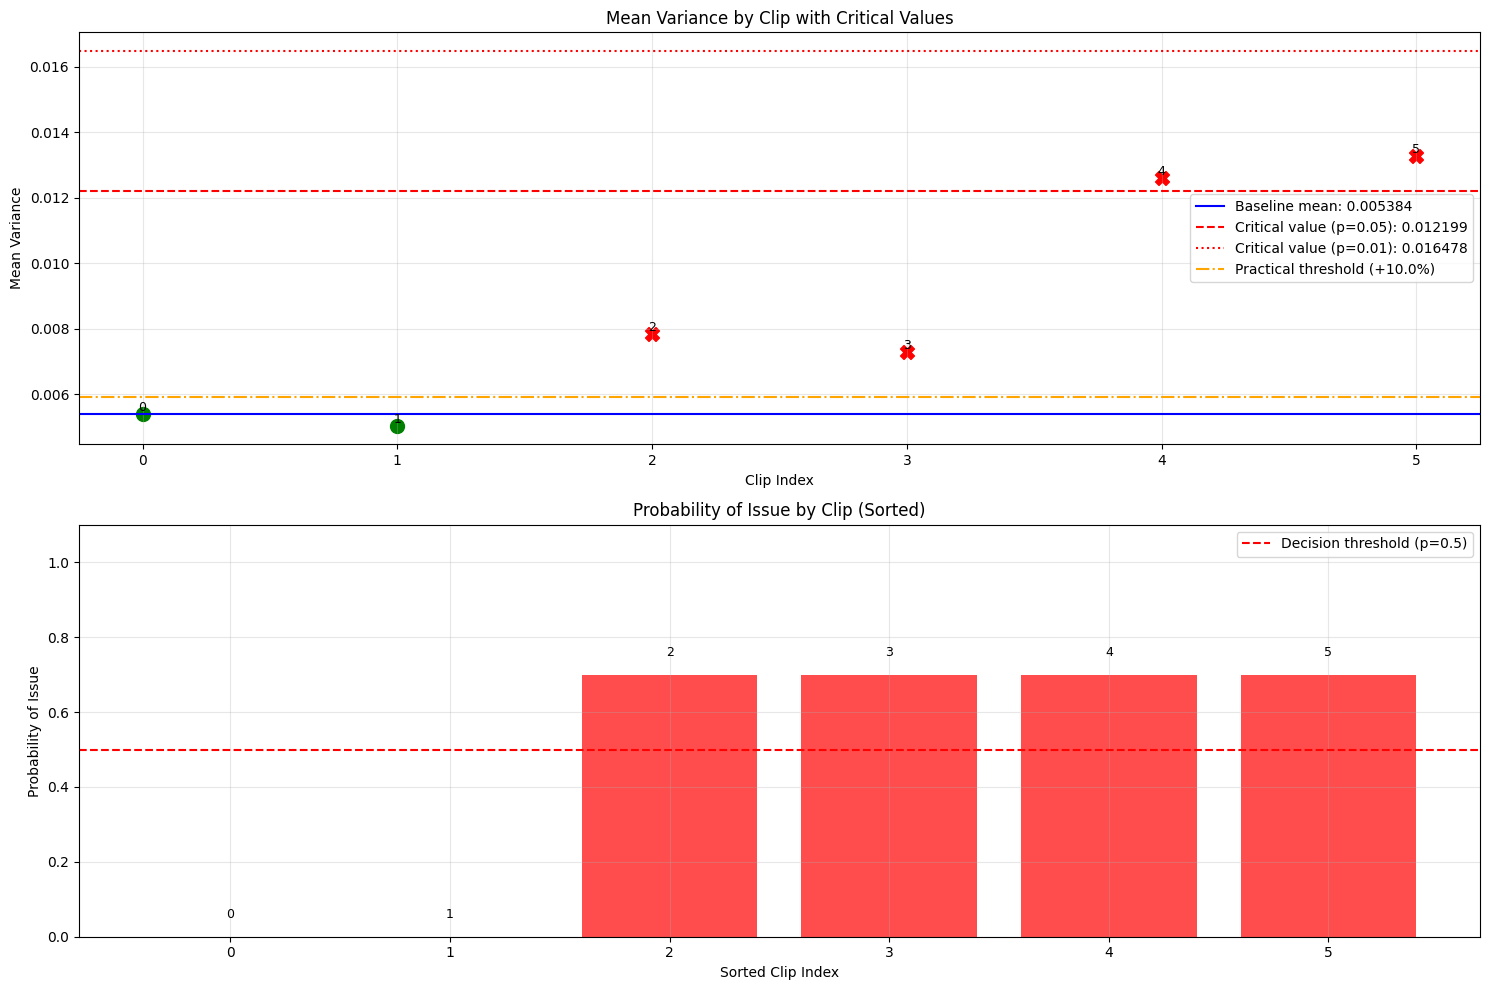

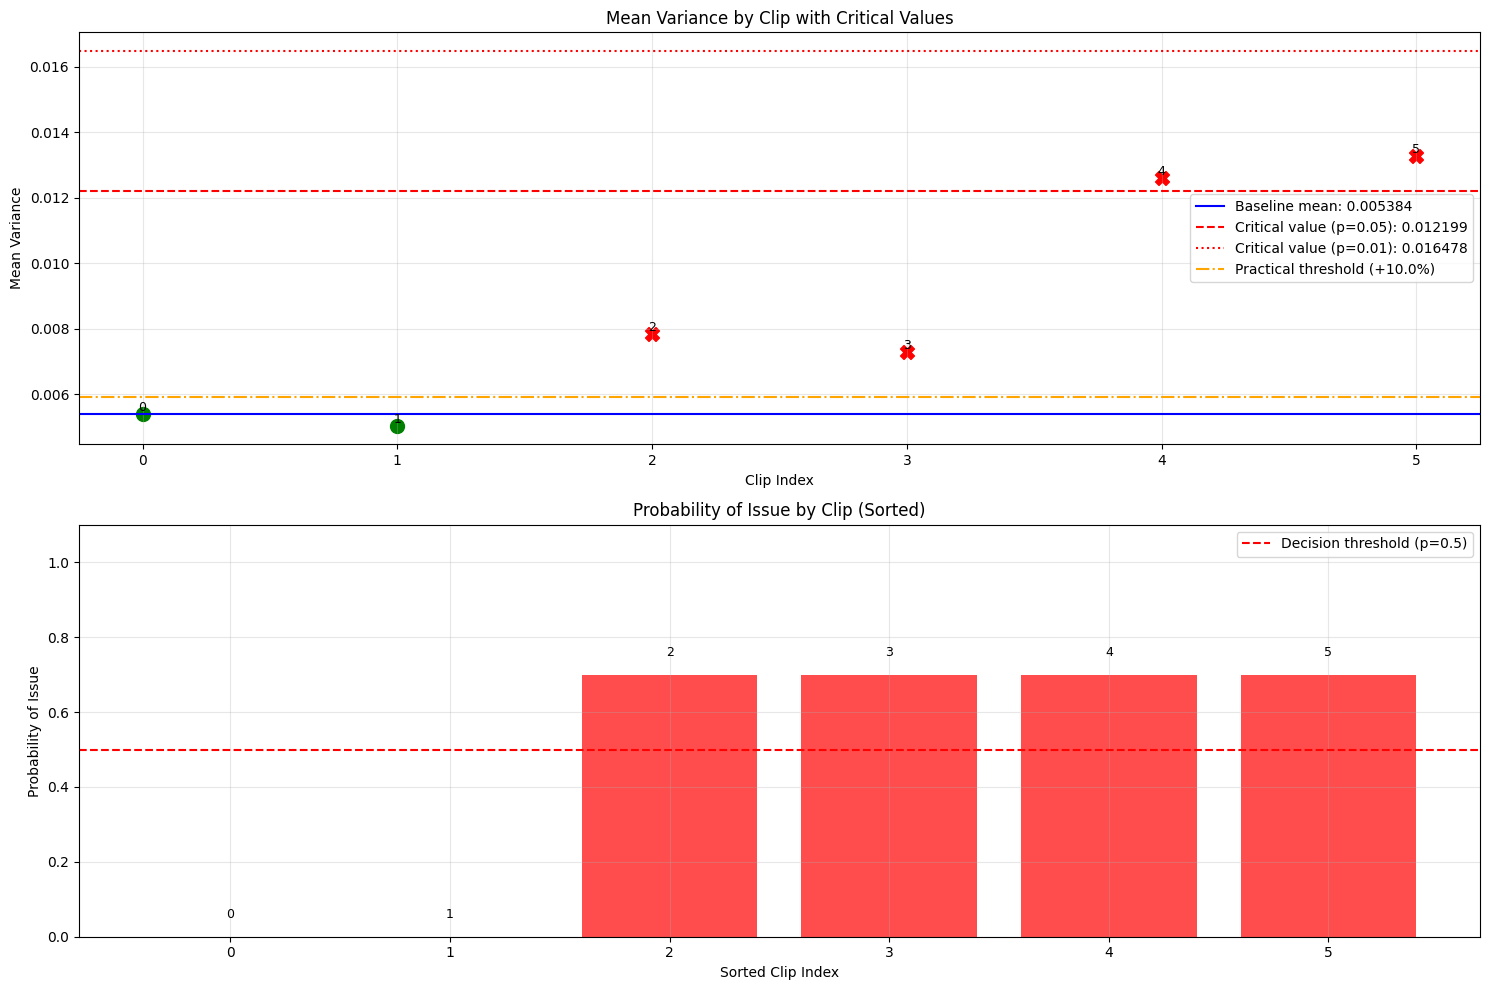

In [6]:
import os
import numpy as np
# Load the saved data
def load_frame_variances(filepath):
    """Load frame variances from pickle file"""
    import pickle
    with open(filepath, 'rb') as f:
        return pickle.load(f)

# Load the data
data = load_frame_variances("saved_data/frame_variances_20250430_145054.pkl")

# Extract components
frame_variances = data['frame_variances']
clip_paths = data['clip_paths']
labels = data['labels']

# Find good clip indices
good_indices = [i for i, label in enumerate(labels) if label == 0]
bad_indices = [i for i, label in enumerate(labels) if label == 1]

# Use first 4 good clips as baseline
baseline_indices = good_indices[:4]
baseline_clips = [frame_variances[i] for i in baseline_indices]
baseline_paths = [clip_paths[i] for i in baseline_indices]

print(f"Using {len(baseline_clips)} clips as baseline:")
for i, path in zip(baseline_indices, baseline_paths):
    print(f"  {i}: {os.path.basename(path) if isinstance(path, str) else path}")

# Process MC dropout data by averaging each frame across MC runs
def process_mc_clip(clip):
    """Average each frame's variance across all MC runs"""
    # Get dimensions
    n_runs = len(clip)
    min_frames = min(len(run) for run in clip)
    
    # Average each frame
    avg_variances = []
    for frame_idx in range(min_frames):
        frame_variances = [clip[run_idx][frame_idx] for run_idx in range(n_runs)]
        avg_variances.append(np.mean(frame_variances))
    
    return np.array(avg_variances)

# Process baseline clips
processed_baseline_clips = [process_mc_clip(clip) for clip in baseline_clips]

# Initialize and set up monitor
# Use a smaller number of MCMC samples for testing
monitor = BayesianYOLOMonitorJAX(
    min_deviation_threshold=0.1,
    credible_interval=0.95,
    mcmc_samples=10000  # Smaller sample size for faster testing
)

# Establish baseline
print("Establishing baseline with Bayesian model...")
baseline_info = monitor.establish_baseline(processed_baseline_clips, visualize=True)
print("Baseline parameters:")
for key, value in baseline_info.items():
    print(f"  {key}: {value}")


# Check all clips using both methods separately
print("\nTesting all clips with both methods:")
for i, clip in enumerate(frame_variances):
    # Process clip
    processed_clip = process_mc_clip(clip)
    
    # Get results from both methods
    results = monitor.check_performance_both(processed_clip)
    prob_result = results['probabilistic']
    pp_result = results['pp_pvalue']
    
    # Is this clip in the baseline?
    in_baseline = i in baseline_indices
    
    # Get expected label (0=good, 1=bad)
    expected = labels[i]
    
    # Evaluate each method separately
    if in_baseline:
        status_prob = "BASELINE"
        status_pp = "BASELINE"
    else:
        status_prob = "CORRECT" if prob_result['has_issue'] == (expected == 1) else "ERROR"
        status_pp = "CORRECT" if pp_result['has_issue'] == (expected == 1) else "ERROR"
    
    print(f"Clip {i} ({os.path.basename(clip_paths[i]) if isinstance(clip_paths[i], str) else clip_paths[i]}):")
    print(f"  Probabilistic: {'Issue detected' if prob_result['has_issue'] else 'OK'} - {status_prob}")
    print(f"    P(below threshold): {prob_result.get('p_below_threshold', 0):.3f}")
    print(f"  P-value Method: {'Issue detected' if pp_result['has_issue'] else 'OK'} - {status_pp}")
    print(f"    P-value: {pp_result.get('pp_pvalue', 1.0):.3f}")
    print(f"  Relative deviation: {results['relative_deviation']:.3f}")
    print()

# Process test clips for evaluation
test_clips = []
test_labels = []
for i in range(len(frame_variances)):
    if i not in baseline_indices:
        processed_clip = process_mc_clip(frame_variances[i])
        test_clips.append(processed_clip)
        test_labels.append(labels[i])

# Evaluate performance
test_results = monitor.run_test(test_clips, test_labels)

print("\nPerformance metrics:")
for metric, value in test_results['metrics'].items():
    if isinstance(value, (int, float)):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

# Visualize results if desired
monitor.visualize_results(test_clips, test_labels)

# Print out comparison between hybrid and individual approaches
print("\nComparison of detection approaches:")
correct_hybrid = 0
correct_threshold = 0
correct_interval = 0
total = len(test_clips)

# Separate evaluation for test clips
test_results_prob = []
test_results_ci = []

for i, (clip, label) in enumerate(zip(test_clips, test_labels)):
    results = monitor.check_performance_both(clip)
    
    # Store results for each method
    test_results_prob.append({
        'predicted': results['probabilistic']['has_issue'], 
        'actual': bool(label),
        'probability': results['probabilistic'].get('p_below_threshold', 0)
    })
    
    test_results_ci.append({
        'predicted': results['pp_pvalue']['has_issue'], 
        'actual': bool(label),
        'outside_ci': results['pp_pvalue'].get('pp_pvalue', 1.0)
    })

# Calculate metrics for each method separately
def calculate_metrics(results):
    correct = sum(1 for r in results if r['predicted'] == r['actual'])
    total = len(results)
    accuracy = correct / total if total > 0 else 0
    
    # Calculate precision, recall, F1
    tp = sum(1 for r in results if r['predicted'] and r['actual'])
    fp = sum(1 for r in results if r['predicted'] and not r['actual'])
    fn = sum(1 for r in results if not r['predicted'] and r['actual'])
    
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'correct': correct,
        'total': total
    }

prob_metrics = calculate_metrics(test_results_prob)
ci_metrics = calculate_metrics(test_results_ci)

print("Performance comparison of the two methods:")
print("\nProbabilistic Method (Threshold approach):")
for metric, value in prob_metrics.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

print("\nPosterior Predictive P-value Method:")
for metric, value in ci_metrics.items():
    if isinstance(value, float):
        print(f"  {metric}: {value:.4f}")
    else:
        print(f"  {metric}: {value}")

# Detailed comparison
print("\nDetailed comparison per test clip:")
for i, (prob_res, ci_res) in enumerate(zip(test_results_prob, test_results_ci)):
    print(f"Test clip {i} (true label={int(prob_res['actual'])}):")
    print(f"  Probabilistic: {'Correct' if prob_res['predicted'] == prob_res['actual'] else 'Wrong'} " +
          f"(predicted={int(prob_res['predicted'])}, p={prob_res['probability']:.3f})")
    print(f"  P-value:      {'Correct' if ci_res['predicted'] == ci_res['actual'] else 'Wrong'} " +
          f"(predicted={int(ci_res['predicted'])}, p-value={1-ci_res['outside_ci']:.3f})")